In [1]:
rm(list = ls(all=TRUE)) # remove all objects
Sys.setlocale("LC_ALL", "zh_CN.UTF-8") # set locale to Chinese
setwd("./") # change working directory

[1] "LC_COLLATE=zh_CN.UTF-8;LC_CTYPE=zh_CN.UTF-8;LC_MONETARY=zh_CN.UTF-8;LC_NUMERIC=C;LC_TIME=zh_CN.UTF-8"

# Data Reading and Preprocessing

## Primitive Variables

### Stock Return

>  Monthly, between the first and last *trading day* of the month (not necessarily beginning and end of the month)

- Read stock return

In [2]:
# Read the stock data using read.csv
stock <- read.csv("stock.csv", header = TRUE, stringsAsFactors = FALSE, check.names = FALSE, colClasses = c(stkcd = "character", year = "integer", month = "integer"))

index_cols <- c("year", "month")

# Clean column names by removing the suffix (like ".SZ") from stock IDs
colnames(stock)[-1] <- gsub("\\.[A-Z]+$", "", colnames(stock)[-1])

# Identify stock return columns (all except date, year, and month)
stock_id <- colnames(stock)[!(colnames(stock) %in% index_cols)]

# Convert all stock ID columns to numeric
for (id in stock_id) {
    stock[[id]] <- as.numeric(stock[[id]])
}

# Display the first few rows of the data
head(stock)

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"not all columns named in 'colClasses' exist"


,year,month,000001,000002,000063,000157,000301,000333,000338,000425,...,688187,688223,688256,688271,688303,688396,688472,688506,688599,688981
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1999,1,-2.5589,-6.5476,-1.1685,NA,NA,NA,NA,-0.3171,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1999,2,-6.0815,-2.1656,-0.2627,NA,NA,NA,NA,-9.8621,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1999,3,0.7358,2.0833,-0.0988,NA,NA,NA,NA,6.5882,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1999,4,-2.1183,15.9439,-12.8214,NA,NA,NA,NA,-5.0773,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1999,5,38.3582,23.7624,10.1323,NA,NA,NA,NA,-0.6977,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1999,6,48.5437,26.7556,89.8312,NA,NA,NA,NA,36.7681,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


- Read listing date

In [3]:
# Read the list_date.csv file
list_time <- read.csv("list_time.csv", header = TRUE, stringsAsFactors = FALSE, colClasses = c(stkcd = "character", year = "integer", month = "integer"))

# Clean stock column by removing the suffix (like ".SZ") from stock IDs
list_time$stkcd <- gsub("\\.[A-Z]+$", "", list_time$stkcd)

head(list_time)

,stkcd,year,month
,<chr>,<int>,<int>
1,000001,1991,4
2,000002,1991,1
3,000063,1997,11
4,000157,2000,10
5,000301,2000,5
6,000333,2013,9


- For each stock, remove observations within the 1 year period after the listing date

In [4]:
# Create a copy of the stock dataframe
stock_filtered <- stock

# Track statistics
affected_stocks <- 0
removed_observations <- 0

# For each stock, remove observations where it has been listed for less than 1 year
for (id in stock_id) {
    # Find the stock in list_time
    idx <- which(list_time$stkcd == id)
    
    if (length(idx) > 0) {
        # Get the listing year and month
        listing_year <- list_time$year[idx]
        listing_month <- list_time$month[idx]
        
        # For each row in stock_filtered
        for (row in 1:nrow(stock_filtered)) {
            current_year <- stock_filtered$year[row]
            current_month <- stock_filtered$month[row]
            
            # Check if this observation is within 1 year of listing
            years_difference <- current_year - listing_year
            months_difference <- current_month - listing_month
            total_months_difference <- years_difference * 12 + months_difference
            
            if (total_months_difference < 12) {
                # Count if this cell has data (not NA) before setting it to NA
                if (!is.na(stock_filtered[row, id])) {
                    removed_observations <- removed_observations + 1
                    if (sum(!is.na(stock_filtered[, id])) > 0) {
                        affected_stocks <- affected_stocks + 1
                    }
                }
                
                # Remove this observation
                stock_filtered[row, id] <- NA
            }
        }
    }
}

# Count unique affected stocks (the previous count might double-count)
affected_stocks <- sum(sapply(stock_id, function(id) {
    any(is.na(stock_filtered[, id])) & any(!is.na(stock[, id]))
}))

# Print summary
cat("Removed observations for", affected_stocks, "stocks that had been listed for less than 1 year\n")
cat("Total observations removed:", removed_observations, "\n")

# Update the stock dataframe
stock <- stock_filtered

head(stock)

Removed observations for 226 stocks that had been listed for less than 1 year
Total observations removed: 2644 


,year,month,000001,000002,000063,000157,000301,000333,000338,000425,...,688187,688223,688256,688271,688303,688396,688472,688506,688599,688981
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1999,1,-2.5589,-6.5476,-1.1685,NA,NA,NA,NA,-0.3171,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1999,2,-6.0815,-2.1656,-0.2627,NA,NA,NA,NA,-9.8621,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1999,3,0.7358,2.0833,-0.0988,NA,NA,NA,NA,6.5882,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1999,4,-2.1183,15.9439,-12.8214,NA,NA,NA,NA,-5.0773,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1999,5,38.3582,23.7624,10.1323,NA,NA,NA,NA,-0.6977,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1999,6,48.5437,26.7556,89.8312,NA,NA,NA,NA,36.7681,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


- Remove stocks with too many missing values under the prioritized criteria:
  1. Remove as fewer stocks as possible
  2. Common time scope of the remaining observations should be closer to latest as possible
  3. Common time scope of the remaining observations should be as long as possible

In [5]:
# Create a copy of the stock dataframe
stock_filtered <- stock

# Create a matrix indicating non-NA values
has_data <- !is.na(stock_filtered[, stock_id])
colnames(has_data) <- stock_id

# Calculate the percentage of non-NA values for each stock
stock_valid_pct <- colMeans(has_data) * 100
names(stock_valid_pct) <- stock_id

# Create a year-month identifier for easier period tracking
stock_filtered$ym <- stock_filtered$year * 100 + stock_filtered$month

# Function to find the common non-NA period for a set of stocks
find_common_period <- function(stocks_subset) {
    # For each period, check if all stocks have data
    all_valid <- apply(has_data[, stocks_subset], 1, all)
    
    # If no common valid dates found, return NULL
    if (!any(all_valid)) {
        return(NULL)
    }
    
    # Find continuous valid periods
    runs <- rle(all_valid)
    valid_run_indices <- which(runs$values)
    
    if (length(valid_run_indices) == 0) {
        return(NULL)
    }
    
    # Find all valid runs and their properties
    valid_periods <- data.frame(
        run_idx = valid_run_indices,
        length = runs$lengths[valid_run_indices],
        stringsAsFactors = FALSE
    )
    
    # Calculate start and end positions for each run
    valid_periods$start_pos <- sapply(valid_periods$run_idx, function(idx) {
        if(idx == 1) 1 else sum(runs$lengths[1:(idx-1)]) + 1
    })
    valid_periods$end_pos <- valid_periods$start_pos + valid_periods$length - 1
    
    # Add start and end year-month
    valid_periods$start_ym <- stock_filtered$ym[valid_periods$start_pos]
    valid_periods$end_ym <- stock_filtered$ym[valid_periods$end_pos]
    
    # Calculate recency score - higher for more recent periods
    max_ym <- max(stock_filtered$ym)
    valid_periods$recency_score <- valid_periods$end_ym / max_ym
    
    # Normalize length
    max_length <- max(valid_periods$length)
    valid_periods$norm_length <- valid_periods$length / max_length
    
    # Combined score: 60% length, 40% recency (favoring recent periods)
    valid_periods$combined_score <- 0.6 * valid_periods$norm_length + 0.4 * valid_periods$recency_score
    
    # Find the period with the highest combined score
    best_idx <- which.max(valid_periods$combined_score)
    
    return(list(
        start_idx = valid_periods$start_pos[best_idx],
        end_idx = valid_periods$end_pos[best_idx],
        length = valid_periods$length[best_idx],
        start_ym = valid_periods$start_ym[best_idx],
        end_ym = valid_periods$end_ym[best_idx],
        combined_score = valid_periods$combined_score[best_idx]
    ))
}

# Initialize variables to store best solution
best_solution <- NULL
best_score <- -Inf

# Try different thresholds to include more or fewer stocks
thresholds <- seq(95, 50, by = -5)

for (threshold in thresholds) {
    # Select stocks with valid data percentage above threshold
    candidate_stocks <- names(stock_valid_pct[stock_valid_pct >= threshold])
    
    # Skip if too few stocks meet the threshold
    if (length(candidate_stocks) < 2) {
        next
    }
    
    # Find common period for these stocks
    period <- find_common_period(candidate_stocks)
    
    # Skip if no common period found
    if (is.null(period)) {
        next
    }
    
    # Total score combines period quality and number of stocks
    # Normalize stock count to give more weight to solutions with more stocks
    stock_ratio <- length(candidate_stocks) / length(stock_id)
    total_score <- period$combined_score + 0.2 * stock_ratio
    
    # Update best solution if better score found
    if (total_score > best_score) {
        best_solution <- list(
            stocks = candidate_stocks,
            start_idx = period$start_idx,
            end_idx = period$end_idx,
            length = period$length,
            start_ym = period$start_ym,
            end_ym = period$end_ym
        )
        best_score <- total_score
    }
}

if (!is.null(best_solution)) {
    # Identify stocks to remove
    stocks_to_remove <- setdiff(stock_id, best_solution$stocks)
    
    # Format year-month for display (YYYY-MM)
    format_ym <- function(ym) {
        year <- floor(ym/100)
        month <- ym %% 100
        return(paste0(year, "-", sprintf("%02d", month)))
    }
    
    # Print summary
    cat("Removing", length(stocks_to_remove), "stocks with excessive NA values:", 
            paste(stocks_to_remove, collapse=", "), "\n")
    cat("Retained", length(best_solution$stocks), "stocks\n")
    cat("Common non-NA period:", format_ym(best_solution$start_ym), "to", 
            format_ym(best_solution$end_ym), "(", best_solution$length, "periods )\n")
    
    # Update stock_id to the selected stocks
    stock_id <- best_solution$stocks
    
    # Filter the dataframe to keep only the selected stocks and date range
    stock_filtered <- stock_filtered[best_solution$start_idx:best_solution$end_idx, c("year", "month", best_solution$stocks)]
    
    # Verify no NA values in the filtered dataset
    cat("NA values in filtered dataset:", sum(is.na(stock_filtered)), "\n")
} else {
    cat("Could not find a common non-NA period for any subset of stocks\n")
}

# Update the stock dataframe
stock <- stock_filtered

head(stock)

Removing 106 stocks with excessive NA values: 000333, 001289, 001965, 001979, 002555, 002594, 002601, 002648, 002709, 002714, 002812, 002916, 002920, 002938, 003816, 300274, 300308, 300316, 300347, 300394, 300408, 300413, 300418, 300433, 300442, 300450, 300498, 300502, 300628, 300661, 300750, 300759, 300760, 300782, 300832, 300896, 300979, 300999, 301269, 600023, 600025, 600905, 600919, 600926, 600938, 600941, 600989, 601012, 601021, 601058, 601100, 601127, 601138, 601225, 601229, 601238, 601360, 601633, 601658, 601669, 601689, 601698, 601728, 601800, 601816, 601838, 601865, 601868, 601916, 601985, 603019, 603195, 603259, 603260, 603288, 603296, 603369, 603392, 603501, 603659, 603799, 603806, 603833, 603986, 603993, 605117, 605499, 688008, 688009, 688012, 688036, 688041, 688082, 688111, 688126, 688169, 688187, 688223, 688256, 688271, 688303, 688396, 688472, 688506, 688599, 688981 
Retained 149 stocks
Common non-NA period: 2012-02 to 2025-03 ( 158 periods )
NA values in filtered dataset

,year,month,000001,000002,000063,000157,000301,000338,000425,000538,...,601857,601872,601877,601888,601898,601899,601939,601988,601989,601998
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
158,2012,2,2.7644,8.2353,15.8784,5.3787,8.1633,3.0088,0.2500,6.5466,...,3.0362,3.8095,12.8434,9.3409,5.3191,6.9820,2.3061,2.3333,9.2058,3.6697
159,2012,3,-8.1287,0.0000,-4.1983,-9.7917,-8.4906,-13.6312,-16.0848,-5.4916,...,-7.8897,-9.4801,1.3158,-5.5473,-8.1818,-13.4737,-1.0246,-2.9316,-7.2727,-5.7522
160,2012,4,5.4106,8.4541,2.3737,14.4342,16.8385,9.8143,13.4473,2.4787,...,2.4768,7.0946,3.4440,13.2341,3.7404,4.6229,-0.8282,2.3490,8.3779,6.3380
161,2012,5,-5.2536,3.0067,-9.2152,9.4854,-4.4118,0.6643,-0.1310,1.0706,...,-4.8338,9.4637,4.8525,-6.2241,-4.2418,-4.4186,-6.2630,-0.6557,-1.8891,-6.4018
162,2012,6,-3.3779,-3.6757,-8.5789,-7.5576,-8.3077,-10.9478,-5.9672,16.6040,...,-2.5618,-6.9200,-4.5654,4.4381,-12.1780,-5.5961,-1.2135,-2.0495,-12.0339,-5.6604
163,2012,7,-0.3958,5.0911,-16.8056,-4.2871,-5.0336,-21.9939,-11.4520,-0.1350,...,-2.0994,-15.8385,-2.4902,-0.2126,-3.3592,-2.9101,-5.4762,-3.1915,-10.7900,1.8135


- Trim extreme values and replace missing values

In [6]:
# Create a copy of the stock dataframe
stock_filtered <- stock

# Make sure data is ordered by year and month
stock_filtered <- stock_filtered[order(stock_filtered$year, stock_filtered$month),]

# Initialize counters for reporting
total_outliers <- 0
total_na_replacements <- 0
outliers_by_stock <- numeric(length(stock_id))
names(outliers_by_stock) <- stock_id

# Function to handle outliers with various methods
replace_outliers <- function(x, method = "interp") {
    # Create a copy of the vector with identified outlier positions as NA
    x_replaced <- x
    
    # Skip if no NA values (no outliers to replace)
    if (!any(is.na(x_replaced))) return(x_replaced)
    
    # Apply chosen replacement method
    if (method == "interp") {
        # Linear interpolation
        na_idx <- which(is.na(x_replaced))
        for (idx in na_idx) {
            # Find nearest non-NA values before and after
            before_idx <- idx - 1
            while(before_idx > 0 && is.na(x_replaced[before_idx])) before_idx <- before_idx - 1
            
            after_idx <- idx + 1
            while(after_idx <= length(x_replaced) && is.na(x_replaced[after_idx])) after_idx <- after_idx + 1
            
            # Interpolate if both bounds exist
            if (before_idx > 0 && after_idx <= length(x_replaced)) {
                x_replaced[idx] <- x_replaced[before_idx] + 
                    (x_replaced[after_idx] - x_replaced[before_idx]) * 
                    (idx - before_idx) / (after_idx - before_idx)
            } else if (before_idx > 0) {
                # If only before exists, use that value
                x_replaced[idx] <- x_replaced[before_idx]
            } else if (after_idx <= length(x_replaced)) {
                # If only after exists, use that value
                x_replaced[idx] <- x_replaced[after_idx]
            } else {
                # Fallback to zero if no reference points
                x_replaced[idx] <- 0
            }
        }
    } else if (method == "median") {
        # Replace with rolling median (window of 5 months)
        window_size <- 5
        na_idx <- which(is.na(x_replaced))
        for (idx in na_idx) {
            # Define window bounds
            start <- max(1, idx - floor(window_size/2))
            end <- min(length(x), idx + floor(window_size/2))
            
            # Get values in window excluding the current NA
            window_values <- x[start:end]
            window_values <- window_values[!is.na(window_values)]
            
            if (length(window_values) > 0) {
                x_replaced[idx] <- median(window_values)
            } else {
                x_replaced[idx] <- 0 # Fallback if all window values are NA
            }
        }
    } else if (method == "zero") {
        # Simple zero replacement
        x_replaced[is.na(x_replaced)] <- 0
    }
    
    return(x_replaced)
}

# Clean each return series
for (id in stock_id) {
    # Use rolling window for adaptive outlier detection
    window_size <- 12 # 12-month rolling window (adjusted from 20 days)
    n <- length(stock_filtered[,id])
    
    for (i in window_size:n) {
        # Define the rolling window
        window_start <- i - window_size + 1
        window_data <- stock_filtered[window_start:i, id]
        current_value <- window_data[window_size]
        
        # Skip if the current value is NA
        if (is.na(current_value)) next
        
        # Calculate robust statistics from the window (excluding current point)
        window_prev <- window_data[-window_size]
        window_median <- median(window_prev, na.rm = TRUE)
        window_mad <- mad(window_prev, na.rm = TRUE)
        
        # Skip if median or MAD is NA or MAD is 0 (no variability)
        if (is.na(window_median) || is.na(window_mad) || window_mad == 0) next
        
        # Use median absolute deviation (MAD) for robust outlier detection
        mad_threshold <- 5 # 5 MADs is a common threshold for extreme outliers
        
        # Check if the current value is an outlier
        if (abs(current_value - window_median) > mad_threshold * window_mad) {
            # Mark as outlier
            stock_filtered[i, id] <- NA
            outliers_by_stock[id] <- outliers_by_stock[id] + 1
            total_outliers <- total_outliers + 1
        }
    }
    
    # Replace outliers and NAs with chosen method
    if (any(is.na(stock_filtered[,id]))) {
        na_count_before <- sum(is.na(stock_filtered[,id]))
        stock_filtered[,id] <- replace_outliers(stock_filtered[,id], method = "interp")
        na_count_after <- sum(is.na(stock_filtered[,id]))
        total_na_replacements <- total_na_replacements + (na_count_before - na_count_after)
    }
}

# Print report
cat("Extreme Value Removal Report:\n")
cat("----------------------------\n")
cat("Total outliers identified and removed:", total_outliers, "\n")
cat("Total missing values replaced:", total_na_replacements, "\n\n")

# Print stocks with the most outliers
if (total_outliers > 0) {
    cat("Stocks with outliers:\n")
    for (id in stock_id) {
        if (outliers_by_stock[id] > 0) {
            cat("  -", id, ":", outliers_by_stock[id], "outliers\n")
        }
    }
}

# Use the cleaned data for further analysis
stock <- stock_filtered

head(stock)

Extreme Value Removal Report:
----------------------------
Total outliers identified and removed: 752 
Total missing values replaced: 752 

Stocks with outliers:
  - 000001 : 4 outliers
  - 000002 : 1 outliers
  - 000063 : 6 outliers
  - 000157 : 2 outliers
  - 000301 : 4 outliers
  - 000338 : 5 outliers
  - 000425 : 2 outliers
  - 000538 : 3 outliers
  - 000625 : 2 outliers
  - 000630 : 18 outliers
  - 000651 : 4 outliers
  - 000661 : 2 outliers
  - 000708 : 2 outliers
  - 000768 : 2 outliers
  - 000786 : 7 outliers
  - 000800 : 2 outliers
  - 000807 : 12 outliers
  - 000858 : 1 outliers
  - 000876 : 6 outliers
  - 000895 : 1 outliers
  - 000938 : 6 outliers
  - 000975 : 4 outliers
  - 000977 : 1 outliers
  - 000983 : 1 outliers
  - 000999 : 8 outliers
  - 002001 : 5 outliers
  - 002007 : 3 outliers
  - 002027 : 3 outliers
  - 002028 : 2 outliers
  - 002049 : 8 outliers
  - 002050 : 1 outliers
  - 002074 : 5 outliers
  - 002129 : 3 outliers
  - 002142 : 10 outliers
  - 002179 : 8 outl

,year,month,000001,000002,000063,000157,000301,000338,000425,000538,...,601857,601872,601877,601888,601898,601899,601939,601988,601989,601998
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
158,2012,2,2.7644,8.2353,15.8784,5.3787,8.1633,3.0088,0.2500,6.5466,...,3.0362,3.8095,12.8434,9.3409,5.3191,6.9820,2.3061,2.3333,9.2058,3.6697
159,2012,3,-8.1287,0.0000,-4.1983,-9.7917,-8.4906,-13.6312,-16.0848,-5.4916,...,-7.8897,-9.4801,1.3158,-5.5473,-8.1818,-13.4737,-1.0246,-2.9316,-7.2727,-5.7522
160,2012,4,5.4106,8.4541,2.3737,14.4342,16.8385,9.8143,13.4473,2.4787,...,2.4768,7.0946,3.4440,13.2341,3.7404,4.6229,-0.8282,2.3490,8.3779,6.3380
161,2012,5,-5.2536,3.0067,-9.2152,9.4854,-4.4118,0.6643,-0.1310,1.0706,...,-4.8338,9.4637,4.8525,-6.2241,-4.2418,-4.4186,-6.2630,-0.6557,-1.8891,-6.4018
162,2012,6,-3.3779,-3.6757,-8.5789,-7.5576,-8.3077,-10.9478,-5.9672,16.6040,...,-2.5618,-6.9200,-4.5654,4.4381,-12.1780,-5.5961,-1.2135,-2.0495,-12.0339,-5.6604
163,2012,7,-0.3958,5.0911,-16.8056,-4.2871,-5.0336,-21.9939,-11.4520,-0.1350,...,-2.0994,-15.8385,-2.4902,-0.2126,-3.3592,-2.9101,-5.4762,-3.1915,-10.7900,1.8135


- Detrend the return series using HP filter

In [7]:
library(mFilter)

# Create a new dataframe to store the cyclical components with year and month
cycle <- data.frame(year = stock$year, month = stock$month)

# Ensure the data is sorted chronologically
cycle <- cycle[order(cycle$year, cycle$month), ]

# Apply HP filter to each stock return series and extract the cyclical component
for (id in stock_id) {
    # Apply HP filter with lambda=14400 (commonly used for monthly financial data)
    hp_filter <- hpfilter(stock[,id], freq=14400)
    
    # Extract the cyclical component and add to cycle dataframe
    cycle[,id] <- hp_filter$cycle
}

# Display the first few rows of the cycle dataframe
head(cycle)

,year,month,000001,000002,000063,000157,000301,000338,000425,000538,...,601857,601872,601877,601888,601898,601899,601939,601988,601989,601998
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012,2,3.2075184,6.0110196,17.045077,5.877316,7.609275,5.297172,3.711529,2.487938,...,4.265861,5.763643,8.989856,7.283536,7.451812,9.5223321,2.6446295,2.4303511,9.657070,4.213759
2,2012,3,-7.8148122,-2.1636423,-3.165317,-9.204487,-9.065980,-11.462619,-12.743277,-9.453418,...,-6.719224,-7.674583,-2.482267,-7.535515,-6.146122,-11.0171053,-0.7274828,-2.8659252,-6.901088,-5.254250
3,2012,4,5.5950344,6.3506784,3.271805,15.109602,16.241236,11.862722,16.668559,-1.386447,...,3.587794,8.751090,-0.299214,11.314528,5.678526,6.9950960,-0.5726787,2.3831298,8.669184,6.789548
4,2012,5,-5.1985218,0.9628145,-8.454121,10.248813,-5.031375,2.592623,2.970365,-2.697566,...,-3.782414,10.970896,1.163063,-8.075517,-2.401834,-2.1313602,-6.0493914,-0.6532538,-1.679006,-5.996874
5,2012,6,-3.4521493,-5.6614423,-7.958186,-6.707170,-8.951040,-9.139911,-2.985890,12.933707,...,-1.570226,-5.562841,-8.202568,2.653582,-10.437286,-3.3947558,-1.0422143,-2.0790111,-11.906652,-5.302716
6,2012,7,-0.5990559,3.1613331,-16.329193,-3.352179,-5.702836,-20.307356,-8.591643,-3.705762,...,-1.167659,-14.633358,-6.077117,-1.931683,-1.719151,-0.7958247,-5.3473206,-3.2533321,-10.747929,2.123340


### VIX

> Daily, close value of the day

In [8]:
# Read the VIX data using read.csv
vix <- read.csv("vix.csv", header = TRUE, stringsAsFactors = FALSE, check.names = FALSE)

# Convert date column to Date format using base R syntax
vix$date <- as.Date(vix$date, format = "%m/%d/%Y")

# Filter to keep only date and close columns
vix <- vix[, c("date", "close")]

# Sort data by date to ensure chronological order
vix <- vix[order(vix$date), ]

# Identify gaps in the time series
date_range <- range(vix$date)
complete_dates <- seq(date_range[1], date_range[2], by = "day")
missing_dates <- complete_dates[!complete_dates %in% vix$date]

# Report missing dates
cat("Found", length(missing_dates), "missing dates in VIX time series\n")

# Create a complete dataframe with all dates
complete_vix <- data.frame(date = complete_dates)

# Merge with actual data, which will result in NA for missing dates
vix_filled <- merge(complete_vix, vix, by = "date", all.x = TRUE)

# Fill missing values using linear interpolation
library(zoo)
vix_filled$close <- na.approx(vix_filled$close, na.rm = FALSE)

# Handle any remaining NAs at the beginning or end 
# that couldn't be interpolated
if (any(is.na(vix_filled$close))) {
    # Fill NAs at beginning with next observation
    vix_filled$close <- na.locf(vix_filled$close, fromLast = TRUE, na.rm = FALSE)
    
    # Fill NAs at end with last observation
    vix_filled$close <- na.locf(vix_filled$close, na.rm = FALSE)
    
    cat("Filled remaining edge values using last/next observation carrying\n")
}

# Update the vix dataframe
vix <- vix_filled

# Quick summary
cat("VIX data now has", nrow(vix), "daily observations with no gaps\n")

# Display the first few rows of the filtered VIX data
head(vix)

Found 3981 missing dates in VIX time series



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




VIX data now has 12890 daily observations with no gaps


,date,close
,<date>,<dbl>
1,1990-01-02,17.24
2,1990-01-03,18.19
3,1990-01-04,19.22
4,1990-01-05,20.11
5,1990-01-06,20.16
6,1990-01-07,20.21


### GFCF

> Monthly, Global Financial Cycle Factor, Common factor across world risky asset prices as in Miranda-Agrippino and Rey (2020), *"US Monetary Policy and the Global Financial Cycle"*

In [9]:
# Read the GFCF data
gfcf <- read.csv("gfcf.csv", header = TRUE, stringsAsFactors = FALSE, colClasses = c(year = "integer", month = "integer"))

# Sort by date to ensure chronological order
gfcf <- gfcf[order(gfcf$year, gfcf$month), ]

# Check for gaps in year-month sequence
min_year <- min(gfcf$year)
max_year <- max(gfcf$year)
min_month <- min(gfcf$month[gfcf$year == min_year])
max_month <- max(gfcf$month[gfcf$year == max_year])

# Create complete sequence of year-month combinations
all_dates <- expand.grid(
    year = min_year:max_year,
    month = 1:12
)
all_dates <- all_dates[
    (all_dates$year > min_year | all_dates$month >= min_month) &
    (all_dates$year < max_year | all_dates$month <= max_month),
]
all_dates <- all_dates[order(all_dates$year, all_dates$month), ]

# Merge with actual data to identify gaps
complete_gfcf <- merge(all_dates, gfcf, by = c("year", "month"), all.x = TRUE)

# Check for missing values after merge
missing_count <- sum(is.na(complete_gfcf$gfcf))

if (missing_count > 0) {
    cat("Found", missing_count, "missing year-month combinations in the GFCF time series\n")
    
    # Fill missing values using interpolation
    library(zoo)
    
    # Create a time index for interpolation (decimal year)
    complete_gfcf$time_idx <- complete_gfcf$year + (complete_gfcf$month - 1) / 12
    
    # Interpolate missing values
    complete_gfcf$gfcf <- na.approx(complete_gfcf$gfcf, x = complete_gfcf$time_idx, na.rm = FALSE)
    
    # Fill any remaining NAs at the beginning or end
    complete_gfcf$gfcf <- na.locf(complete_gfcf$gfcf, fromLast = TRUE, na.rm = FALSE)
    complete_gfcf$gfcf <- na.locf(complete_gfcf$gfcf, na.rm = FALSE)
    
    # Remove the time index column (was just for interpolation)
    complete_gfcf$time_idx <- NULL
} else {
    cat("No gaps detected in the GFCF year-month sequence\n")
}

# Update the gfcf dataframe
gfcf <- complete_gfcf[order(complete_gfcf$year, complete_gfcf$month), ]

# Verify no more missing values
final_missing <- sum(is.na(gfcf$gfcf))
cat("Missing values after filling:", final_missing, "\n")

# Display summary statistics
cat("\nGFCF data summary:\n")
summary(gfcf$gfcf)

# Display the first few rows
head(gfcf)

No gaps detected in the GFCF year-month sequence
Missing values after filling: 0 

GFCF data summary:


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.9187 -0.6181 -0.1932  0.0000  0.6341  2.5922 

,year,month,gfcf
,<int>,<int>,<dbl>
4,1980,2,-1.1689039
5,1980,3,-1.7800666
6,1980,4,-1.7658765
7,1980,5,-1.5713119
8,1980,6,-1.3698628
9,1980,7,-0.9472969


### Capital Inflow

> Quarterly, normalized by quarter GDP value in USD

In [10]:
# Read the capital inflow data
inflow <- read.csv("channel_inflow.csv", header = TRUE, stringsAsFactors = FALSE, 
                   colClasses = c(year = "integer", quarter = "integer"))

# Sort by date to ensure chronological order
inflow <- inflow[order(inflow$year, inflow$quarter), ]

# Check for gaps in year-quarter sequence
min_year <- min(inflow$year)
max_year <- max(inflow$year)
min_quarter <- min(inflow$quarter[inflow$year == min_year])
max_quarter <- max(inflow$quarter[inflow$year == max_year])

# Create complete sequence of year-quarter combinations
all_dates <- expand.grid(
    year = min_year:max_year,
    quarter = 1:4
)
all_dates <- all_dates[
    (all_dates$year > min_year | all_dates$quarter >= min_quarter) &
    (all_dates$year < max_year | all_dates$quarter <= max_quarter),
]
all_dates <- all_dates[order(all_dates$year, all_dates$quarter), ]

# Add month column for each quarter's end (Q1=3, Q2=6, Q3=9, Q4=12)
all_dates$month <- all_dates$quarter * 3

# Merge with actual data to identify gaps
complete_inflow <- merge(all_dates, inflow, by = c("year", "quarter"), all.x = TRUE)

# Check for missing values after merge
missing_count <- sum(is.na(complete_inflow$inflow))

if (missing_count > 0) {
    cat("Found", missing_count, "missing year-quarter combinations in the inflow time series\n")
    
    # Fill missing values using interpolation
    library(zoo)
    
    # Create a time index for interpolation (decimal year)
    complete_inflow$time_idx <- complete_inflow$year + (complete_inflow$quarter - 1) / 4
    
    # Interpolate missing values
    complete_inflow$inflow <- na.approx(complete_inflow$inflow, x = complete_inflow$time_idx, na.rm = FALSE)
    
    # Fill any remaining NAs at the beginning or end
    complete_inflow$inflow <- na.locf(complete_inflow$inflow, fromLast = TRUE, na.rm = FALSE)
    complete_inflow$inflow <- na.locf(complete_inflow$inflow, na.rm = FALSE)
    
    # Remove the time index column (was just for interpolation)
    complete_inflow$time_idx <- NULL
} else {
    cat("No gaps detected in the inflow year-quarter sequence\n")
}

# Update the inflow dataframe
inflow <- complete_inflow[order(complete_inflow$year, complete_inflow$quarter), ]

# Verify no more missing values
final_missing <- sum(is.na(inflow$inflow))
cat("Missing values after filling:", final_missing, "\n")

# Display summary statistics
cat("\nCapital inflow data summary:\n")
summary(inflow$inflow)

# Display the first few rows
head(inflow)

No gaps detected in the inflow year-quarter sequence
Missing values after filling: 0 

Capital inflow data summary:


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.02753  0.02209  0.03705  0.03844  0.05724  0.12311 

,year,quarter,month,inflow
,<int>,<int>,<dbl>,<dbl>
1,1998,1,3,0.02541250
2,1998,2,6,0.05021401
3,1998,3,9,0.01700843
4,1998,4,12,0.04201171
5,1999,1,3,0.02496356
6,1999,2,6,0.04111106


### Control

> Quarterly, quarter-end month observation

#### Micro

- Read the micro part of control variable and balance the panel

- Dataset has already received the following cleansing before input:
  1. Removed:
     - stocks from the financial sector
     - stocks incurred ST/ST*/PT during observation period
  2. Winsorized: 5% on both ends

In [11]:
# Read the control_micro data
control_micro <- read.csv("control_micro.csv", header = TRUE, stringsAsFactors = FALSE, 
        colClasses = c(stkcd = "character", year = "integer", quarter = "integer", month = "integer"))

index_cols <- c("stkcd", "year", "quarter", "month")
var_cols <- c("Size", "Lev", "ROA", "BM", "Board", "Top1", "SOE")

control_micro <- control_micro[, c(index_cols, var_cols)]

# Find the earliest and latest year-quarter combinations
min_year <- min(control_micro$year)
min_quarter <- min(control_micro$quarter[control_micro$year == min_year])
max_year <- max(control_micro$year)
max_quarter <- max(control_micro$quarter[control_micro$year == max_year])

cat("Date range for all stocks:", min_year, "Q", min_quarter, "to", max_year, "Q", max_quarter, "\n")

# Create a complete sequence of year-quarter combinations
all_dates <- expand.grid(
  year = min_year:max_year,
  quarter = 1:4
)

# Filter to keep only dates within the identified range
all_dates <- all_dates[
  (all_dates$year > min_year | all_dates$quarter >= min_quarter) &
  (all_dates$year < max_year | all_dates$quarter <= max_quarter),
]
all_dates <- all_dates[order(all_dates$year, all_dates$quarter), ]

# Add month column based on quarter (Q1=3, Q2=6, Q3=9, Q4=12)
all_dates$month <- all_dates$quarter * 3

# Get unique stock codes
unique_stocks <- unique(control_micro$stkcd)

# Create an empty dataframe to hold the balanced panel
balanced_control_micro <- data.frame()

# For each stock, add missing dates
for (stock in unique_stocks) {
  # Get data for this stock
  stock_data <- control_micro[control_micro$stkcd == stock, ]
  
  # Create stock-specific complete date sequence
  stock_dates <- data.frame(
  stkcd = stock,
  year = all_dates$year,
  quarter = all_dates$quarter,
  month = all_dates$month
  )
  
  # Merge with actual data (will add NA for missing dates)
  complete_stock_data <- merge(
  stock_dates,
  stock_data,
  by = index_cols,
  all.x = TRUE
  )
  
  # Add to the balanced panel
  balanced_control_micro <- rbind(balanced_control_micro, complete_stock_data)
}

# Sort the balanced panel
balanced_control_micro <- balanced_control_micro[order(balanced_control_micro$stkcd, balanced_control_micro$year, balanced_control_micro$quarter), c(index_cols, var_cols)]

# Display summary statistics
cat("Original data had", nrow(control_micro), "observations\n")
cat("Balanced panel has", nrow(balanced_control_micro), "observations\n")
cat("Added", nrow(balanced_control_micro) - nrow(control_micro), "missing observations\n")

# Calculate how many stocks have missing observations
stocks_with_gaps <- sapply(unique_stocks, function(stock) {
  stock_data <- control_micro[control_micro$stkcd == stock, ]
  expected_obs <- nrow(all_dates)
  actual_obs <- nrow(stock_data)
  return(expected_obs != actual_obs)
})

cat("Number of stocks with time gaps:", sum(stocks_with_gaps), "out of", length(unique_stocks), "\n")

# Update the control_micro dataframe
control_micro <- balanced_control_micro

# Display the first few rows
head(control_micro)

Date range for all stocks: 2000 Q 2 to 2022 Q 4 
Original data had 192512 observations
Balanced panel has 452179 observations
Added 259667 missing observations
Number of stocks with time gaps: 4969 out of 4969 


,stkcd,year,quarter,month,Size,Lev,ROA,BM,Board,Top1,SOE
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,000002,2000,2,6,22.34171,0.4275993,NA,0.7333718,2.833213,NA,NA
2,000002,2000,3,9,NA,NA,NA,NA,NA,NA,NA
3,000002,2000,4,12,22.45000,0.4725161,0.061516,0.7892044,2.833213,NA,NA
4,000002,2001,1,3,NA,NA,NA,NA,NA,NA,NA
5,000002,2001,2,6,22.52588,0.4879012,NA,0.8042830,2.564949,NA,NA
6,000002,2001,3,9,NA,NA,NA,NA,NA,NA,NA


In [12]:
# Read industry classification data
ind_type <- read.csv("ind_type.csv", header = TRUE, stringsAsFactors = FALSE, 
                    colClasses = c(stkcd = "character", year = "integer"))

# Ensure stock code format consistency for merging
if(any(grepl("\\.", ind_type$stkcd))) {
  ind_type$stkcd <- gsub("\\.[A-Z]+$", "", ind_type$stkcd)
}

# Check for duplicate entries
duplicates <- ind_type[duplicated(ind_type[, c("year", "stkcd")]) | 
                      duplicated(ind_type[, c("year", "stkcd")], fromLast = TRUE), ]
if(nrow(duplicates) > 0) {
  cat("Warning: Found", nrow(duplicates)/2, "duplicate year-stock combinations in industry data\n")
}

# Merge with control_micro using inner join
control_micro_with_ind <- merge(
  control_micro,
  ind_type,
  by = c("year", "stkcd"),
  all.x = FALSE
)

# Check dimensions before and after merge
cat("Rows in control_micro before merge:", nrow(control_micro), "\n")
cat("Rows after merge with industry data:", nrow(control_micro_with_ind), "\n")
cat("Stocks with missing industry information:", 
    length(setdiff(unique(control_micro$stkcd), unique(control_micro_with_ind$stkcd))), "\n")

# Convert industry codes to factors for regression analysis
control_micro_with_ind$ind <- factor(control_micro_with_ind$ind)

# Update the control_micro dataframe
control_micro <- control_micro_with_ind

# Display the first few rows of the merged data
head(control_micro)

Rows in control_micro before merge: 452179 
Rows after merge with industry data: 166952 
Stocks with missing industry information: 4 


,year,stkcd,quarter,month,Size,Lev,ROA,BM,Board,Top1,SOE,ind
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,2008,000002,4,12,25.31735,0.6744409,0.042309,1.9096906,2.397895,0.147255,0,K
2,2008,000002,1,3,25.31735,0.6654745,0.007196,0.6847717,2.397895,NA,0,K
3,2008,000002,3,9,25.31735,0.6966075,0.023780,1.9215522,2.397895,NA,0,K
4,2008,000002,2,6,25.31735,0.6775643,0.021844,1.2738179,2.397895,0.146345,0,K
5,2008,000005,1,3,21.11211,0.4897155,0.001542,0.2352045,2.708050,NA,0,S
6,2008,000005,2,6,21.09840,0.4804520,0.003770,0.4166303,2.708050,0.201386,0,S


- Treat the missing values

In [13]:
library(zoo)

# Check how many missing values we have in each column
missing_values <- colSums(is.na(control_micro))
cat("Missing values per column:\n")
print(missing_values)

# Calculate percentage of missing values by column
pct_missing <- round(missing_values / nrow(control_micro) * 100, 2)
cat("\nPercentage of missing values:\n")
print(pct_missing)

# For visualization, get missing pattern by stock and time
missing_by_stock <- tapply(rowSums(is.na(control_micro[, var_cols])), 
                          control_micro$stkcd, mean)
missing_by_time <- aggregate(rowSums(is.na(control_micro[, var_cols])), 
                            by = list(year = control_micro$year, 
                                     quarter = control_micro$quarter), 
                            mean)

# Impute missing values based on variable characteristics
control_micro_imputed <- control_micro

# Approach for each variable:
for (id in unique(control_micro$stkcd)) {
  # Get data for this stock only
  stock_data <- control_micro[control_micro$stkcd == id, ]
  stock_data <- stock_data[order(stock_data$year, stock_data$quarter), ]
  
  for (var in var_cols) {
    # Skip if no missing values for this variable and stock
    if (!any(is.na(stock_data[, var]))) next
    
    # Choose imputation method based on variable type
    if (var %in% c("Size", "Lev", "ROA", "BM")) {
      # For financial metrics that change gradually, use interpolation
      stock_data[, var] <- na.approx(stock_data[, var], na.rm = FALSE)
      
      # Handle any remaining NAs at the beginning with next observation
      if (any(is.na(stock_data[, var]))) {
        stock_data[, var] <- na.locf(stock_data[, var], fromLast = TRUE, na.rm = FALSE)
        
        # Handle any remaining NAs at the end with last observation
        stock_data[, var] <- na.locf(stock_data[, var], na.rm = FALSE)
      }
    } else if (var %in% c("Board", "Top1", "SOE", "ind1", "ind2")) {
      # For governance metrics that change infrequently, use LOCF
      stock_data[, var] <- na.locf(stock_data[, var], na.rm = FALSE)
      
      # If there are still NAs at the beginning, use NOCB
      if (any(is.na(stock_data[, var]))) {
        stock_data[, var] <- na.locf(stock_data[, var], fromLast = TRUE, na.rm = FALSE)
      }
      
      # For any remaining NAs (if entire series is NA), use cross-sectional median
      if (any(is.na(stock_data[, var]))) {
        # Get the median value from the whole dataset for this variable
        var_median <- median(control_micro[, var], na.rm = TRUE)
        stock_data[is.na(stock_data[, var]), var] <- var_median
      }
    }
  }
  
  # Update the imputed dataset with this stock's data
  control_micro_imputed[control_micro_imputed$stkcd == id, ] <- stock_data
}

# Check if any missing values remain
missing_after <- colSums(is.na(control_micro_imputed))
cat("\nMissing values after imputation:\n")
print(missing_after)

# Display summary statistics before and after imputation
cat("\nSummary before imputation:\n")
print(summary(control_micro[, var_cols]))

cat("\nSummary after imputation:\n")
print(summary(control_micro_imputed[, var_cols]))

# Update the control_micro dataframe
control_micro <- control_micro_imputed

# Display the first few rows of the imputed data
head(control_micro)

Missing values per column:
   year   stkcd quarter   month    Size     Lev     ROA      BM   Board    Top1 
      0       0       0       0    4659    4659    4669    5454    4671   22499 
    SOE     ind 
   4658       0 

Percentage of missing values:
   year   stkcd quarter   month    Size     Lev     ROA      BM   Board    Top1 
   0.00    0.00    0.00    0.00    2.79    2.79    2.80    3.27    2.80   13.48 
    SOE     ind 
   2.79    0.00 

Missing values after imputation:
   year   stkcd quarter   month    Size     Lev     ROA      BM   Board    Top1 
      0       0       0       0       0       0       0       0       0       0 
    SOE     ind 
      0       0 

Summary before imputation:
      Size            Lev              ROA                BM         
 Min.   :19.37   Min.   :0.0253   Min.   :-0.1634   Min.   : 0.0520  
 1st Qu.:21.15   1st Qu.:0.2462   1st Qu.: 0.0059   1st Qu.: 0.3636  
 Median :21.91   Median :0.4089   Median : 0.0203   Median : 0.6300  
 Mean   :22.

,year,stkcd,quarter,month,Size,Lev,ROA,BM,Board,Top1,SOE,ind
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,2008,000002,1,3,25.31735,0.6654745,0.007196,0.6847717,2.397895,0.146345,0,K
2,2008,000002,2,6,25.31735,0.6775643,0.021844,1.2738179,2.397895,0.146345,0,K
3,2008,000002,3,9,25.31735,0.6966075,0.023780,1.9215522,2.397895,0.146345,0,K
4,2008,000002,4,12,25.31735,0.6744409,0.042309,1.9096906,2.397895,0.147255,0,K
5,2008,000005,1,3,21.11211,0.4897155,0.001542,0.2352045,2.708050,0.201386,0,S
6,2008,000005,2,6,21.09840,0.4804520,0.003770,0.4166303,2.708050,0.201386,0,S


#### Macro

- Read the macro part of control variable

In [14]:
# Read the control_macro data
control_macro <- read.csv("control_macro.csv", header = TRUE, stringsAsFactors = FALSE, 
              colClasses = c(year = "integer", quarter = "integer", month = "integer"))

index_cols <- c("year", "quarter", "month")
var_cols <- c("gdp_growth_rate", "m2_growth_rate")

# Sort by date to ensure chronological order
control_macro <- control_macro[order(control_macro$year, control_macro$quarter), ][, c(index_cols, var_cols)]

# Find the earliest and latest year-quarter combinations
min_year <- min(control_macro$year)
min_quarter <- min(control_macro$quarter[control_macro$year == min_year])
max_year <- max(control_macro$year)
max_quarter <- max(control_macro$quarter[control_macro$year == max_year])

cat("Date range:", min_year, "Q", min_quarter, "to", max_year, "Q", max_quarter, "\n")

# Create a complete sequence of year-quarter combinations
all_dates <- expand.grid(
  year = min_year:max_year,
  quarter = 1:4
)

# Filter to keep only dates within the identified range
all_dates <- all_dates[
  (all_dates$year > min_year | all_dates$quarter >= min_quarter) &
  (all_dates$year < max_year | all_dates$quarter <= max_quarter),
]
all_dates <- all_dates[order(all_dates$year, all_dates$quarter), ]

# Add month column (last month of each quarter)
all_dates$month <- all_dates$quarter * 3

# Merge with actual data (will add NA for missing dates)
complete_control_macro <- merge(
  all_dates,
  control_macro,
  by = index_cols,
  all.x = TRUE
)

# Handle merged month columns if they exist
if ("month.y" %in% colnames(complete_control_macro)) {
  # Use month.y values where available, otherwise use month.x
  complete_control_macro$month <- ifelse(
    is.na(complete_control_macro$month.y),
    complete_control_macro$month.x,
    complete_control_macro$month.y
  )
  
  # Remove the extra month columns
  complete_control_macro$month.x <- NULL
  complete_control_macro$month.y <- NULL
}

# Count missing periods
non_date_cols <- setdiff(names(complete_control_macro), index_cols)
missing_periods <- sum(apply(complete_control_macro[, non_date_cols, drop=FALSE], 1, function(x) all(is.na(x))))

# Report results
cat("Found", missing_periods, "missing year-quarter combinations\n")
if (missing_periods > 0) {
  cat("Added missing periods with NA values for observations\n")
}

# Update the control_macro dataframe
control_macro <- complete_control_macro[order(complete_control_macro$year, complete_control_macro$quarter), ]

# Display the first few rows
head(control_macro)

Date range: 2003 Q 1 to 2024 Q 4 
Found 1 missing year-quarter combinations
Added missing periods with NA values for observations


,year,quarter,month,gdp_growth_rate,m2_growth_rate
,<int>,<int>,<dbl>,<dbl>,<dbl>
1,2003,1,3,NA,NA
2,2003,2,6,0.08903639,0.04413487
3,2003,3,9,0.08490761,0.04925471
4,2003,4,12,0.12746553,0.03426695
5,2004,1,3,-0.12967664,0.04955063
6,2004,2,6,0.11803645,0.03350321


- Treat the missing values

In [15]:
# Check current missing values in control_macro data
missing_values <- colSums(is.na(control_macro))
cat("Missing values in control_macro:\n")
print(missing_values)

# Impute missing values for each economic variable
library(zoo)
library(forecast)

# Create a time index for better time series handling
control_macro$time_idx <- control_macro$year + (control_macro$quarter - 1) / 4

# Sort data by time
control_macro <- control_macro[order(control_macro$time_idx), ]

# Function to impute missing economic time series data
impute_economic_ts <- function(x, time_idx) {
    # If no missing values, return as is
    if(!any(is.na(x))) return(x)
    
    # For short gaps (1-2 periods), use spline interpolation
    x_spline <- na.spline(x, na.rm = FALSE)
    
    # For remaining gaps, try time series methods
    if(any(is.na(x_spline))) {
        # Create a time series object
        ts_data <- ts(x, frequency = 4)  # Quarterly data has frequency 4
        
        # Simple imputation with seasonal components
        x_seadec <- na.seadec(ts_data, algorithm = "interpolation")
        
        # Replace values still missing after spline with these estimates
        na_idx <- which(is.na(x_spline))
        x_spline[na_idx] <- x_seadec[na_idx]
        
        # If still have missing values (e.g., at edges), use ARIMA forecasting
        if(any(is.na(x_spline))) {
            # First fill leading NAs with the first non-NA value
            if(is.na(x_spline[1])) {
                first_valid <- min(which(!is.na(x_spline)))
                x_spline[1:first_valid-1] <- x_spline[first_valid]
            }
            
            # Then fill trailing NAs with the last non-NA value
            if(is.na(x_spline[length(x_spline)])) {
                last_valid <- max(which(!is.na(x_spline)))
                x_spline[last_valid+1:length(x_spline)] <- x_spline[last_valid]
            }
        }
    }
    
    return(x_spline)
}

# Apply imputation to each economic variable
control_macro$gdp_growth_rate <- impute_economic_ts(control_macro$gdp_growth_rate, control_macro$time_idx)
control_macro$m2_growth_rate <- impute_economic_ts(control_macro$m2_growth_rate, control_macro$time_idx)

# Remove the time index after imputation
control_macro$time_idx <- NULL

# Check if imputation was successful
missing_after <- colSums(is.na(control_macro))
cat("\nMissing values after imputation:\n")
print(missing_after)

# Verify the imputed data makes economic sense
cat("\nSummary of imputed economic variables:\n")
cat("GDP growth rate summary:\n")
print(summary(control_macro$gdp_growth_rate))
cat("\nM2 growth rate summary:\n")
print(summary(control_macro$m2_growth_rate))

# Display the first few rows to check for patterns
head(control_macro)

Missing values in control_macro:
           year         quarter           month gdp_growth_rate  m2_growth_rate 
              0               0               0               1               1 


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 




Missing values after imputation:
           year         quarter           month gdp_growth_rate  m2_growth_rate 
              0               0               0               0               0 

Summary of imputed economic variables:
GDP growth rate summary:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.25702  0.03761  0.08028  0.04166  0.11251  0.58151 

M2 growth rate summary:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.03933  0.01921  0.03236  0.03199  0.04113  0.10565 


,year,quarter,month,gdp_growth_rate,m2_growth_rate
,<int>,<int>,<dbl>,<dbl>,<dbl>
1,2003,1,3,0.58151038,-0.03933086
2,2003,2,6,0.08903639,0.04413487
3,2003,3,9,0.08490761,0.04925471
4,2003,4,12,0.12746553,0.03426695
5,2004,1,3,-0.12967664,0.04955063
6,2004,2,6,0.11803645,0.03350321


#### Merge Micro & Macro

In [16]:
# Merge the control_micro and control_macro datasets
# This will add macro variables to each stock in each time period

# First, check dimensions of input datasets
cat("Control_micro dimensions:", dim(control_micro)[1], "observations,", dim(control_micro)[2], "variables\n")
cat("Control_macro dimensions:", dim(control_macro)[1], "observations,", dim(control_macro)[2], "variables\n")

# Perform the merge using merge() function with an inner join approach
control <- merge(
    control_micro,  # Stock-level micro controls
    control_macro,  # Time-level macro controls
    by = c("year", "quarter", "month"),  # Join keys
    all.x = FALSE,  # Inner join to keep only matched records
    all.y = FALSE
)

# Verify the structure of the merged dataset
cat("\nMerged control dataset dimensions:", dim(control)[1], "observations,", dim(control)[2], "variables\n")
cat("Number of stocks in merged dataset:", length(unique(control$stkcd)), "\n")
cat("Time period covered:", min(paste(control$year, "Q", control$quarter)), "to", 
        max(paste(control$year, "Q", control$quarter)), "\n")

# Check for missing values in key columns
missing_counts <- colSums(is.na(control))
if (any(missing_counts > 0)) {
    cat("\nMissing values found in the following columns:\n")
    print(missing_counts[missing_counts > 0])
} else {
    cat("\nNo missing values in the merged dataset\n")
}

# Display the first few rows of the merged dataset
head(control)

Control_micro dimensions: 166952 observations, 12 variables
Control_macro dimensions: 88 observations, 5 variables

Merged control dataset dimensions: 166952 observations, 14 variables
Number of stocks in merged dataset: 4965 
Time period covered: 2008 Q 1 to 2022 Q 4 

No missing values in the merged dataset


,year,quarter,month,stkcd,Size,Lev,ROA,BM,Board,Top1,SOE,ind,gdp_growth_rate,m2_growth_rate
,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>
1,2008,1,3,000002,25.31735,0.6654745,0.007196,0.6847717,2.397895,0.146345,0,K,-0.1157663,0.05393113
2,2008,1,3,600285,20.70395,0.4129128,0.001340,0.4533193,2.197225,0.094434,1,C27,-0.1157663,0.05393113
3,2008,1,3,002192,19.65011,0.3093229,-0.002974,0.3012335,2.079442,0.331843,0,C25,-0.1157663,0.05393113
4,2008,1,3,000859,21.36608,0.4419385,0.002923,0.5352634,2.302585,0.340578,1,C29,-0.1157663,0.05393113
5,2008,1,3,000005,21.11211,0.4897155,0.001542,0.2352045,2.708050,0.201386,0,S,-0.1157663,0.05393113
6,2008,1,3,600287,22.00931,0.6698279,0.002023,0.8710921,1.791759,0.497270,1,F,-0.1157663,0.05393113


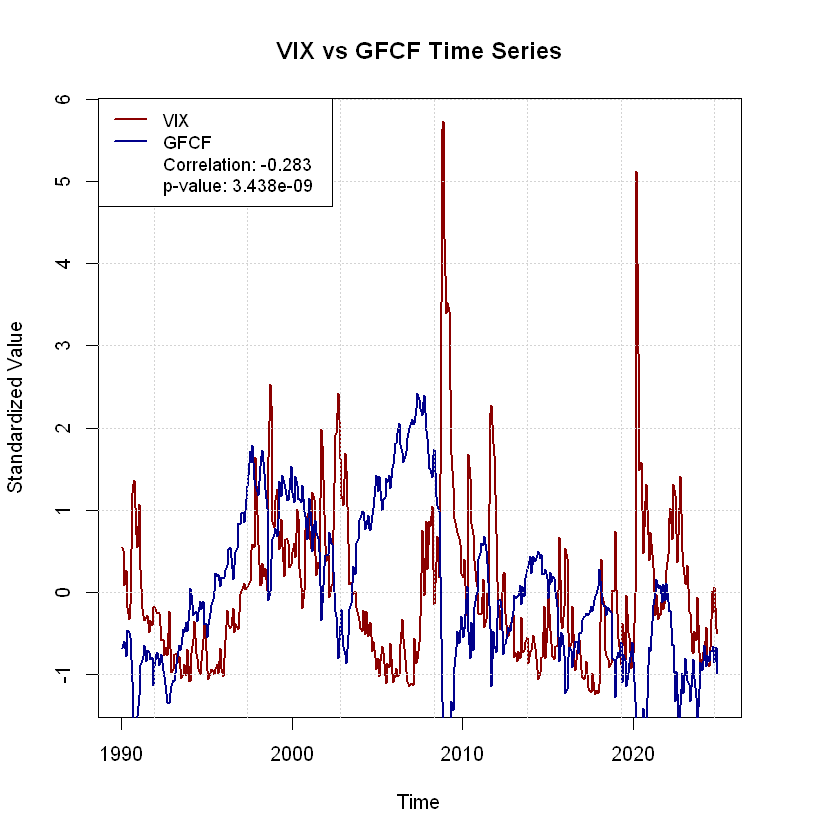

In [17]:
# Prepare data for time series plots
library(ggplot2)
library(scales)
library(gridExtra)

# Extract year and month from date column in vix
vix$year <- as.integer(format(vix$date, "%Y"))
vix$month <- as.integer(format(vix$date, "%m"))

# Convert VIX to monthly data
vix_monthly <- aggregate(close ~ year + month, data = vix, FUN = mean)

# Create a time index for sorting and plotting
vix_monthly$date <- as.Date(paste(vix_monthly$year, vix_monthly$month, "15", sep = "-"))
gfcf$date <- as.Date(paste(gfcf$year, gfcf$month, "15", sep = "-"))

# Merge VIX and GFCF data
merged_ts <- merge(vix_monthly[, c("date", "close")], 
                       gfcf[, c("date", "gfcf")], 
                       by = "date", all = FALSE)

# Calculate correlation coefficient and p-value
cor_test <- cor.test(merged_ts$close, merged_ts$gfcf)
cor_coef <- cor_test$estimate
p_value <- cor_test$p.value

par(bg = "white", mar = c(5, 4, 4, 4) + 0.1)

# Plot time series
plot(merged_ts$date, z_vix <- scale(merged_ts$close), type = "l", col = "darkred", 
      xlab = "Time", ylab = "Standardized Value",
      main = "VIX vs GFCF Time Series", lwd = 2)
lines(merged_ts$date, z_gfcf <- scale(merged_ts$gfcf), col = "darkblue", lwd = 2)

# Add grid for readability
grid()

# Combined legend with both line types and correlation info
legend("topleft", 
        legend = c("VIX", "GFCF", 
                     paste("Correlation:", round(cor_coef, 3)),
                     paste("p-value:", format.pval(p_value, digits = 4))),
        col = c("darkred", "darkblue", NA, NA),
        lty = c(1, 1, NA, NA),
        lwd = c(2, 2, NA, NA),
        bty = "o",
        bg = "white",
        cex = 0.9)


## Panel preparation

### Variable Calculation

#### GFC

In [18]:
# 1. Process VIX for quarter-end values
vix$year <- as.integer(format(vix$date, "%Y"))
vix$month <- as.integer(format(vix$date, "%m"))
vix$quarter <- ceiling(vix$month / 3)

# Find last trading day of each quarter
vix_quarter_end <- aggregate(
    cbind(date, close) ~ year + quarter, 
    data = vix, 
    FUN = function(x) x[which.max(as.Date(x))]
)
vix_quarter_end$month <- vix_quarter_end$quarter * 3  # Last month of quarter

# 2. Process VIX for quarterly averages
vix_quarterly_avg <- aggregate(close ~ year + quarter, data = vix, FUN = mean)
vix_quarterly_avg$month <- vix_quarterly_avg$quarter * 3

# 3. Process GFCF for quarter-end values
gfcf_quarter_end <- gfcf[gfcf$month %in% c(3, 6, 9, 12), ]
gfcf_quarter_end$quarter <- ceiling(gfcf_quarter_end$month / 3)

# Calculate logs and first differences
# 1. VIX quarter-end
vix_quarter_end$log_vix <- log(vix_quarter_end$close)
vix_quarter_end <- vix_quarter_end[order(vix_quarter_end$year, vix_quarter_end$quarter), ]
vix_quarter_end$log_diff <- c(NA, diff(vix_quarter_end$log_vix))

# 2. VIX quarterly average
vix_quarterly_avg$log_vix_avg <- log(vix_quarterly_avg$close)
vix_quarterly_avg <- vix_quarterly_avg[order(vix_quarterly_avg$year, vix_quarterly_avg$quarter), ]
vix_quarterly_avg$log_diff_avg <- c(NA, diff(vix_quarterly_avg$log_vix_avg))

# 3. GFCF quarter-end - CHANGED: using direct difference instead of log difference
gfcf_quarter_end <- gfcf_quarter_end[order(gfcf_quarter_end$year, gfcf_quarter_end$quarter), ]
gfcf_quarter_end$diff_gfcf <- c(NA, diff(gfcf_quarter_end$gfcf))

# Merge indicators using inner joins to keep only periods with all data available
# First merge VIX quarter-end with VIX quarterly average
gfc_indicators <- merge(
    vix_quarter_end[, c("year", "quarter", "month", "log_diff")],
    vix_quarterly_avg[, c("year", "quarter", "log_diff_avg")],
    by = c("year", "quarter"),
    all = FALSE  # Inner join
)

# Then merge with GFCF quarter-end - CHANGED: using diff_gfcf instead of log_diff_gfcf
gfc_indicators <- merge(
    gfc_indicators,
    gfcf_quarter_end[, c("year", "quarter", "diff_gfcf")],
    by = c("year", "quarter"),
    all = FALSE  # Inner join
)

# Sort chronologically
gfc_indicators <- gfc_indicators[order(gfc_indicators$year, gfc_indicators$quarter), ]

# Add lagged values (for t-1 period)
gfc_indicators$log_diff_lag1 <- c(NA, gfc_indicators$log_diff[-nrow(gfc_indicators)])
gfc_indicators$log_diff_avg_lag1 <- c(NA, gfc_indicators$log_diff_avg[-nrow(gfc_indicators)])
gfc_indicators$diff_gfcf_lag1 <- c(NA, gfc_indicators$diff_gfcf[-nrow(gfc_indicators)])

# Add date column for easier merging
gfc_indicators$date <- as.Date(paste(gfc_indicators$year, gfc_indicators$month, "01", sep = "-"))

gfc_indicators <- gfc_indicators[, c("year", "month", "quarter", "log_diff_lag1", "log_diff_avg_lag1", "diff_gfcf_lag1")]

# Remove rows with NA for lagged values (first period)
gfc_indicators <- gfc_indicators[!is.na(gfc_indicators$log_diff_lag1), ]

# Display summary
cat("GFC indicators calculated for", nrow(gfc_indicators), "quarters\n")
head(gfc_indicators)

GFC indicators calculated for 138 quarters


,year,month,quarter,log_diff_lag1,log_diff_avg_lag1,diff_gfcf_lag1
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1990,9,3,-0.12035515,-0.16693099,0.11544264
4,1990,12,4,0.41179163,0.29528976,-1.08445686
5,1991,3,1,-0.07071789,0.02621695,0.07670249
6,1991,6,2,0.06328700,-0.15112439,0.67129779
7,1991,9,3,-0.58734477,-0.26578044,-0.01359283
8,1991,12,4,0.05181503,-0.02721769,0.02934118


#### Volatility

- Calculate the volatility as the standard deviation of return rate cycle component within a 48-month (4-year) rolling window

In [19]:
library(zoo)

# Create a new dataframe to store the volatilities with year and month from cycle
volatility <- data.frame(year = cycle$year, month = cycle$month)

# Set the window size for rolling volatility calculation
window_size <- 48 # 48 months

# Ensure data is sorted chronologically
cycle <- cycle[order(cycle$year, cycle$month), ]
volatility <- volatility[order(volatility$year, volatility$month), ]

# Calculate simple rolling standard deviation for each stock
for (id in stock_id) {
    # Use rollapply with standard deviation function
    vol <- rollapply(cycle[,id], width=window_size, 
                    FUN=function(x) sd(x, na.rm=TRUE), 
                    fill=NA, align="right")
    volatility[,id] <- vol
}

# Remove rows with NA values (first 47 observations due to the rolling window)
volatility <- na.omit(volatility)

# Add quarter column
volatility$quarter <- ceiling(volatility$month / 3)  # Calculate quarter from month

# Reorder columns to put year, quarter, month first, followed by stock columns
volatility <- volatility[, c("year", "quarter", "month", stock_id)]

# Display the first few rows of the volatility dataframe
head(volatility)


,year,quarter,month,000001,000002,000063,000157,000301,000338,000425,...,601857,601872,601877,601888,601898,601899,601939,601988,601989,601998
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48,2016,1,1,11.12355,9.253694,10.36819,8.614711,10.66467,8.384462,10.86323,...,5.498045,13.19412,7.315076,6.999269,11.08972,11.02880,6.496128,5.750086,12.35487,10.51822
49,2016,1,2,11.13727,9.219553,10.09476,8.599081,10.61434,8.360619,10.84743,...,5.460883,13.17024,7.197324,7.070943,11.03373,11.05998,6.541287,5.741362,12.27668,10.51063
50,2016,1,3,11.18649,9.219607,10.16105,8.700393,10.68461,8.358254,11.06297,...,5.436743,13.21019,7.212554,7.118779,11.02220,10.95722,6.615632,5.819976,12.76728,10.63625
51,2016,2,4,11.15866,9.176814,10.20220,8.458706,10.42040,8.185450,10.81323,...,5.413795,13.14946,7.282186,6.939559,10.98761,10.91621,6.636956,5.813161,12.79760,10.60346
52,2016,2,5,11.13431,9.179539,10.16375,8.316153,10.44452,8.190901,10.82345,...,5.389511,13.05255,7.278994,6.852661,11.02849,10.94166,6.605485,5.812899,12.79711,10.57233
53,2016,2,6,11.12291,9.148981,10.10884,8.268319,10.36937,8.110892,10.83932,...,5.387518,13.03673,7.188860,6.837364,10.98823,11.01500,6.612699,5.806923,12.70478,10.55278


- Convert the original volatility table from wide to long form

In [20]:
library(reshape2)

# Filter the volatility data to keep only quarterly data (March, June, September, December)
volatility_long <- volatility

# Reshape from wide to long format
volatility_molten <- melt(
    volatility_long,
    id.vars = c("year", "month", "quarter"),
    measure.vars = stock_id,
    variable.name = "stkcd",
    value.name = "volatility"
)

# Ensure stkcd is character type for consistent merging
volatility_molten$stkcd <- as.character(volatility_molten$stkcd)

# Create a new dataframe with selected columns
volatility <- volatility_molten[, c("stkcd", "year", "quarter", "month", "volatility")]

# Check for time series continuity
# Count observations per stock
obs_per_stock <- table(volatility$stkcd)
cat("Observations per stock - summary:\n")
print(summary(as.numeric(obs_per_stock)))

# Check if all stocks have the same number of time periods
expected_periods <- length(unique(paste(volatility$year, volatility$month, sep="-")))
cat("\nExpected number of periods per stock:", expected_periods, "\n")
cat("Number of stocks with complete data:", sum(obs_per_stock == expected_periods), 
    "out of", length(obs_per_stock), "\n")

# Check for any stocks with incomplete time series
if(any(obs_per_stock != expected_periods)) {
  cat("\nStocks with incomplete time series:\n")
  incomplete_stocks <- names(obs_per_stock)[obs_per_stock != expected_periods]
  print(data.frame(
    Stock = incomplete_stocks,
    Observations = as.numeric(obs_per_stock[incomplete_stocks]),
    Missing = expected_periods - as.numeric(obs_per_stock[incomplete_stocks])
  ))
}

# Display the first few rows of the melted data
head(volatility)

Observations per stock - summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    111     111     111     111     111     111 

Expected number of periods per stock: 111 
Number of stocks with complete data: 149 out of 149 


,stkcd,year,quarter,month,volatility
,<chr>,<int>,<dbl>,<int>,<dbl>
1,000001,2016,1,1,11.12355
2,000001,2016,1,2,11.13727
3,000001,2016,1,3,11.18649
4,000001,2016,2,4,11.15866
5,000001,2016,2,5,11.13431
6,000001,2016,2,6,11.12291


- Take logarithm of volatility

In [21]:
# Create a copy of the volatility dataframe for log transformation
volatility_log <- volatility

# Check for non-positive values in the volatility column
non_positive_count <- sum(volatility_log$volatility <= 0, na.rm = TRUE)
if (non_positive_count > 0) {
    cat("Warning:", non_positive_count, "non-positive volatility values found.\n")
    cat("Adding a small constant before log transformation to handle zeros/negatives.\n")
    
    # Add a small constant to handle zeros and negative values
    min_positive <- min(volatility_log$volatility[volatility_log$volatility > 0], na.rm = TRUE)
    offset <- min_positive * 0.001  # Small fraction of the minimum positive value
    volatility_log$volatility <- volatility_log$volatility + offset
}

# Apply log transformation
volatility_log$volatility <- log(volatility_log$volatility)

# Verify the transformation
cat("Volatility summary before log transformation:\n")
print(summary(volatility$volatility))
cat("\nVolatility summary after log transformation:\n")
print(summary(volatility_log$volatility))

# Update the volatility dataframe with log-transformed values
volatility <- volatility_log

# Display the first few rows of the transformed dataframe
head(volatility)

Volatility summary before log transformation:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.147   7.411   9.463   9.566  11.472  26.839 

Volatility summary after log transformation:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7639  2.0030  2.2474  2.1976  2.4399  3.2898 


,stkcd,year,quarter,month,volatility
,<chr>,<int>,<dbl>,<int>,<dbl>
1,000001,2016,1,1,2.409065
2,000001,2016,1,2,2.410297
3,000001,2016,1,3,2.414707
4,000001,2016,2,4,2.412216
5,000001,2016,2,5,2.410032
6,000001,2016,2,6,2.409007


- Remove stocks incurred extreme volatility within observation period

In [22]:
# Load required libraries for normality tests and statistics
library(moments)  # For skewness and kurtosis functions

# Initialize an empty vector to store outlier stock IDs
outlier_stocks <- character(0)

# Function to measure distance from normal distribution
# Lower value = closer to normal distribution
normality_distance <- function(x) {
  # Calculate absolute skewness (0 for normal) and excess kurtosis (0 for normal)
  sk <- abs(skewness(x, na.rm = TRUE))
  kt <- abs(kurtosis(x, na.rm = TRUE) - 3)  # Normal kurtosis is 3
  
  # Combined distance metric
  return(sk + kt/2)  # Weighting kurtosis less as it's more sensitive
}

# Get unique year-month combinations
periods <- unique(volatility[, c("year", "month")])

# For each year-month period, transform distribution toward normal
for (i in 1:nrow(periods)) {
  curr_year <- periods$year[i]
  curr_month <- periods$month[i]
  
  # Get data for this period
  period_data <- volatility[volatility$year == curr_year & volatility$month == curr_month, ]
  
  # Skip if too few stocks for meaningful distribution shaping
  if (nrow(period_data) < 10) next
  
  # Calculate initial normality distance
  initial_distance <- normality_distance(period_data$volatility)
  
  # Prepare working copy of data
  working_data <- period_data
  period_stocks <- working_data$stkcd
  period_values <- working_data$volatility
  
  # Set maximum percentage of stocks to remove (to avoid over-pruning)
  max_remove_pct <- 0.1  # 10% maximum removal
  max_removals <- floor(length(period_stocks) * max_remove_pct)
  
  # Iteratively remove extreme values
  removals <- 0
  period_outliers <- character(0)
  
  while (removals < max_removals) {
    # Find current mean and standard deviation
    curr_mean <- mean(period_values, na.rm = TRUE)
    curr_sd <- sd(period_values, na.rm = TRUE)
    
    # Calculate z-scores to identify extremes
    z_scores <- abs((period_values - curr_mean) / curr_sd)
    
    # Find the most extreme value (highest z-score)
    max_idx <- which.max(z_scores)
    
    # Temporarily remove it
    test_values <- period_values[-max_idx]
    
    # Check if removal improves normality
    new_distance <- normality_distance(test_values)
    
    # Stop if no improvement or minimal improvement
    if (new_distance >= initial_distance || (initial_distance - new_distance) < 0.05) {
      break
    }
    
    # Otherwise, keep this removal
    period_outliers <- c(period_outliers, period_stocks[max_idx])
    period_stocks <- period_stocks[-max_idx]
    period_values <- test_values
    removals <- removals + 1
    initial_distance <- new_distance
  }
  
  # Add to our master list of outlier stocks
  outlier_stocks <- unique(c(outlier_stocks, period_outliers))
  
  # Report progress if significant removals made
  if (length(period_outliers) > 0) {
    cat(sprintf("Period %d-%02d: Removed %d stocks to improve normality\n", 
                curr_year, curr_month, length(period_outliers)))
  }
}

# Print the stocks to be removed
cat("Removing", length(outlier_stocks), "stocks to make distributions more normal\n")

# Create a filtered version of the volatility dataframe
volatility_filtered <- volatility[!volatility$stkcd %in% outlier_stocks, ]

# Update stock_id list to exclude outlier stocks
stock_id <- stock_id[!stock_id %in% outlier_stocks]

# Print summary statistics before and after filtering
cat("\nBefore filtering:", nrow(volatility), "observations,", length(unique(volatility$stkcd)), "stocks\n")
cat("After filtering:", nrow(volatility_filtered), "observations,", length(unique(volatility_filtered$stkcd)), "stocks\n")

# Update the main volatility dataframe
volatility <- volatility_filtered

# Display the first few rows of the filtered dataframe
head(volatility)

Period 2016-01: Removed 1 stocks to improve normality
Period 2016-03: Removed 1 stocks to improve normality
Period 2016-04: Removed 1 stocks to improve normality
Period 2016-05: Removed 1 stocks to improve normality
Period 2016-06: Removed 1 stocks to improve normality
Period 2016-07: Removed 1 stocks to improve normality
Period 2016-08: Removed 1 stocks to improve normality
Period 2016-09: Removed 1 stocks to improve normality
Period 2016-10: Removed 1 stocks to improve normality
Period 2016-11: Removed 1 stocks to improve normality
Period 2016-12: Removed 1 stocks to improve normality
Period 2017-01: Removed 1 stocks to improve normality
Period 2017-02: Removed 1 stocks to improve normality
Period 2017-03: Removed 1 stocks to improve normality
Period 2017-04: Removed 1 stocks to improve normality
Period 2017-05: Removed 1 stocks to improve normality
Period 2017-06: Removed 1 stocks to improve normality
Period 2018-01: Removed 1 stocks to improve normality
Period 2018-05: Removed 1 st

,stkcd,year,quarter,month,volatility
,<chr>,<int>,<dbl>,<int>,<dbl>
1,000001,2016,1,1,2.409065
2,000001,2016,1,2,2.410297
3,000001,2016,1,3,2.414707
4,000001,2016,2,4,2.412216
5,000001,2016,2,5,2.410032
6,000001,2016,2,6,2.409007


In [23]:
# 1. Filter for quarter-end volatility (month is 3, 6, 9, or 12)
volatility_quarter_end <- volatility[volatility$month %in% c(3, 6, 9, 12), ]

# 2. Calculate quarterly average volatility for each stock
volatility_avg <- aggregate(
    volatility ~ stkcd + year + quarter,
    data = volatility,
    FUN = mean
)

# 3. Merge quarter-end data with quarterly average
volatility_quarterly <- merge(
    volatility_quarter_end,
    volatility_avg[, c("stkcd", "year", "quarter", "volatility")],
    by = c("stkcd", "year", "quarter"),
    all.x = TRUE,
    suffixes = c("_end", "_avg")
)

# 4. Create a clean dataframe with the required columns
volatility <- volatility_quarterly[, c("stkcd", "year", "quarter", "month", "volatility_end", "volatility_avg")]


# Report the dimensions of the new dataset
cat("New quarterly volatility dataset has", nrow(volatility), "observations for", 
        length(unique(volatility$stkcd)), "stocks\n")

# Display the first few rows of the updated volatility dataframe
head(volatility)

New quarterly volatility dataset has 4995 observations for 135 stocks


,stkcd,year,quarter,month,volatility_end,volatility_avg
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,000001,2016,1,3,2.414707,2.411356
2,000001,2016,2,6,2.409007,2.410418
3,000001,2016,3,9,2.404304,2.407613
4,000001,2016,4,12,2.353794,2.387311
5,000001,2017,1,3,2.303832,2.317413
6,000001,2017,2,6,2.212951,2.264951


- Visualization


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"The dot-dot notation (`..x..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(x)` instead."
Picking joint bandwidth of 0.093

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


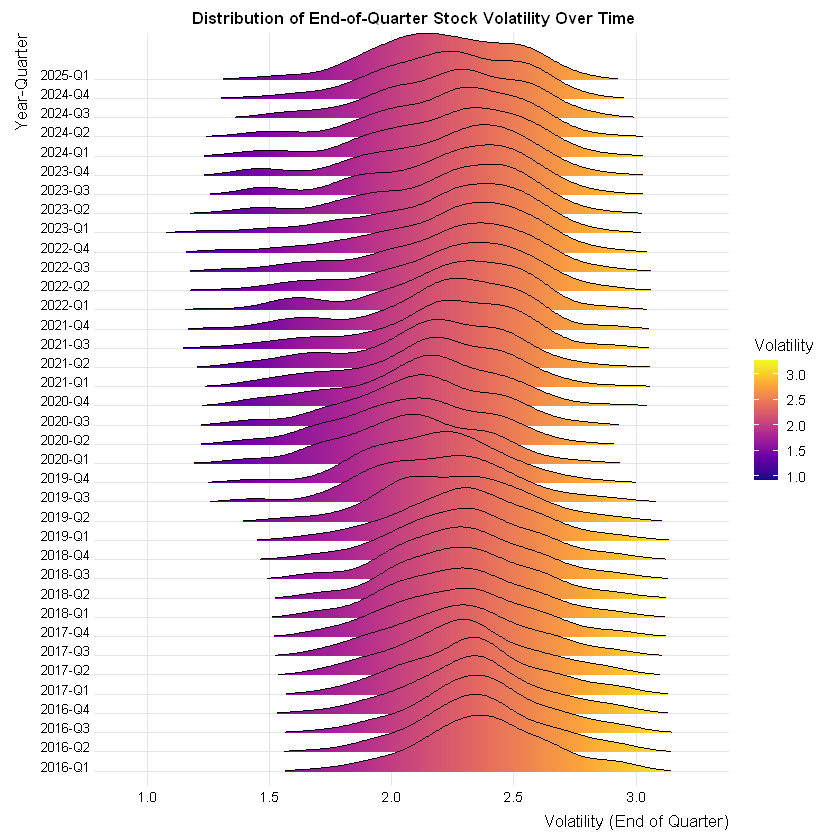

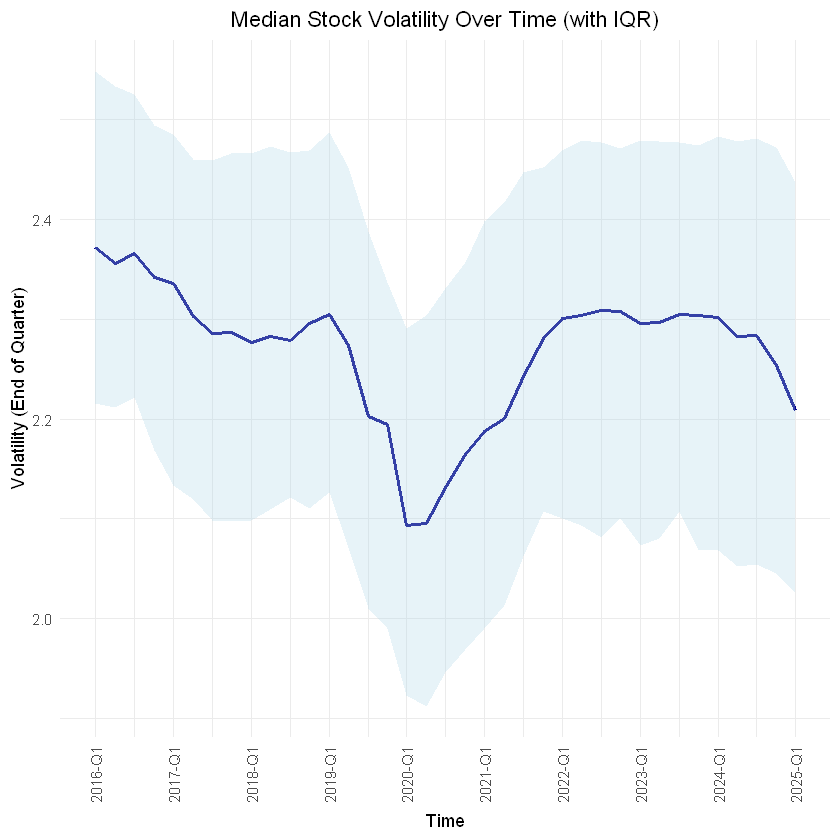

In [24]:
# Load required libraries
library(ggplot2)
library(ggridges)
library(dplyr)

# Create a copy of the volatility dataframe for visualization
vol_viz <- volatility

# Create a proper year-quarter factor for chronological ordering
vol_viz$yearquarter <- paste0(vol_viz$year, "-Q", vol_viz$quarter)

# Create a chronologically ordered factor for the y-axis
unique_yearquarters <- unique(vol_viz$yearquarter[order(vol_viz$year, vol_viz$quarter)])
vol_viz$yearquarter <- factor(vol_viz$yearquarter, levels = unique_yearquarters)

# Ridge plot of volatility distributions over time
ggplot(vol_viz, aes(x = volatility_end, y = yearquarter, fill = ..x..)) +
  geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01, alpha = 0.8) +
  scale_fill_viridis_c(name = "Volatility", option = "C") +
  labs(title = "Distribution of End-of-Quarter Stock Volatility Over Time",
       x = "Volatility (End of Quarter)",
       y = "Year-Quarter") +
  theme_ridges(font_size = 10, grid = TRUE) +
  theme(
    legend.position = "right",
    axis.text.y = element_text(size = 8, hjust = 1),
    plot.title = element_text(hjust = 0.5),
    panel.spacing.y = unit(0.5, "lines")
  )

# Create a summary of volatility measures for time series visualization
vol_summary <- vol_viz %>%
  group_by(year, quarter, yearquarter) %>%
  summarize(
    median_vol = median(volatility_end, na.rm = TRUE),
    q25 = quantile(volatility_end, 0.25, na.rm = TRUE),
    q75 = quantile(volatility_end, 0.75, na.rm = TRUE),
    .groups = "drop"
  )

# Convert yearquarter to a factor with same ordering
vol_summary$yearquarter <- factor(vol_summary$yearquarter, levels = unique_yearquarters)

# Time series plot showing median volatility and IQR
ggplot(vol_summary, aes(x = as.numeric(yearquarter), y = median_vol)) +
  geom_line(size = 1, color = "darkblue") +
  geom_ribbon(aes(ymin = q25, ymax = q75), alpha = 0.3, fill = "lightblue") +
  labs(title = "Median Stock Volatility Over Time (with IQR)",
       x = "Time", 
       y = "Volatility (End of Quarter)") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)
  ) +
  # Add custom x-axis labels with appropriate gaps
  scale_x_continuous(
    breaks = seq(1, length(unique_yearquarters), by = 4),
    labels = unique_yearquarters[seq(1, length(unique_yearquarters), by = 4)]
  )

### Data Merging

- 1. Merge volatility with GFC indicators

In [25]:
panel_data <- merge(
    volatility,
    gfc_indicators,
    by = c("year", "month", "quarter"),
    all.x = TRUE
)

# Show a sample of the final merged dataset
head(panel_data)

,year,month,quarter,stkcd,volatility_end,volatility_avg,log_diff_lag1,log_diff_avg_lag1,diff_gfcf_lag1
,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016,3,1,600482,2.438525,2.439948,-0.5130372,-0.1340702,0.06858532
2,2016,3,1,600438,2.331690,2.340306,-0.5130372,-0.1340702,0.06858532
3,2016,3,1,601766,2.371816,2.369645,-0.5130372,-0.1340702,0.06858532
4,2016,3,1,600028,1.760594,1.743084,-0.5130372,-0.1340702,0.06858532
5,2016,3,1,601699,2.495432,2.493065,-0.5130372,-0.1340702,0.06858532
6,2016,3,1,600027,2.438201,2.436851,-0.5130372,-0.1340702,0.06858532


- 2. Merge with control variables

In [26]:
panel_data <- merge(
    panel_data,
    control,
    by = c("stkcd", "year", "quarter", "month"),
    all.x = FALSE
)

# Display column names to verify what's available
cat("Columns in merged panel_data:\n")
print(names(panel_data))

# Create factor variables for fixed effects
panel_data$quarter <- factor(panel_data$quarter)  # Quarter fixed effects

# Check for missing data in key columns
missing_counts <- colSums(is.na(panel_data))
cat("Missing value counts in final panel dataset:\n")
print(missing_counts[missing_counts > 0])

# Show a sample of the final merged dataset
head(panel_data)

Columns in merged panel_data:
 [1] "stkcd"             "year"              "quarter"          
 [4] "month"             "volatility_end"    "volatility_avg"   
 [7] "log_diff_lag1"     "log_diff_avg_lag1" "diff_gfcf_lag1"   
[10] "Size"              "Lev"               "ROA"              
[13] "BM"                "Board"             "Top1"             
[16] "SOE"               "ind"               "gdp_growth_rate"  
[19] "m2_growth_rate"   
Missing value counts in final panel dataset:
named numeric(0)


,stkcd,year,quarter,month,volatility_end,volatility_avg,log_diff_lag1,log_diff_avg_lag1,diff_gfcf_lag1,Size,Lev,ROA,BM,Board,Top1,SOE,ind,gdp_growth_rate,m2_growth_rate
,<chr>,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>
1,000002,2016,1,3,2.221332,2.222561,-0.51303720,-0.13407018,0.06858532,26.03564,0.7894035,0.001968,2.772296,2.397895,0.152436,0,K,-0.15585196,0.03873796
2,000002,2016,2,6,2.213642,2.215767,0.14301884,0.18856999,-0.02142195,26.03564,0.8060189,0.010720,2.997288,2.397895,0.152436,0,K,0.11625103,0.02571886
3,000002,2016,3,9,2.458129,2.407451,-0.08836915,-0.26805092,-0.12204480,26.03564,0.8101231,0.016516,2.970462,2.397895,0.152436,0,K,0.05316315,0.02763126
4,000002,2016,4,12,2.497818,2.474038,-0.35070346,-0.17293136,0.29816244,26.03564,0.8053671,0.039322,4.156858,2.397895,0.152436,0,K,0.10665503,0.01794285
5,000002,2017,1,3,2.465599,2.471818,0.21584021,0.05901848,0.11982483,26.10168,0.8173269,0.001292,4.431021,2.397895,0.153055,0,K,-0.14072811,0.03956675
6,000002,2017,2,6,2.459049,2.464600,-0.51535237,-0.18363093,0.19498112,26.10168,0.8265752,0.011424,3.827082,2.397895,0.256343,0,K,0.11005946,0.01488211


- 3. Merge with Capital Inflow

In [27]:
# Merge panel_data with inflow data based on year and quarter
# Using inflow data read previously
panel_data <- merge(
    panel_data,
    inflow[, c("year", "quarter", "month", "inflow")],
    by = c("year", "quarter", "month"),
    all.x = TRUE
)

# Check for missing values in the inflow variable
cat("Missing values in inflow variable:", sum(is.na(panel_data$inflow)), "\n")

# Display dimensions of the enhanced panel dataset
cat("\nPanel dataset dimensions after adding inflow data: ", 
    nrow(panel_data), "observations,", ncol(panel_data), "variables\n")

# Display a sample of the merged data
head(panel_data)


Missing values in inflow variable: 0 

Panel dataset dimensions after adding inflow data:  3556 observations, 20 variables


,year,quarter,month,stkcd,volatility_end,volatility_avg,log_diff_lag1,log_diff_avg_lag1,diff_gfcf_lag1,Size,Lev,ROA,BM,Board,Top1,SOE,ind,gdp_growth_rate,m2_growth_rate,inflow
,<int>,<fct>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>
1,2016,1,3,000002,2.221332,2.222561,-0.5130372,-0.1340702,0.06858532,26.03564,0.7894035,0.001968,2.7722964,2.397895,0.152436,0,K,-0.155852,0.03873796,-0.007274988
2,2016,1,3,000768,2.709447,2.706603,-0.5130372,-0.1340702,0.06858532,24.33632,0.5457232,-0.001966,0.6921163,2.302585,0.381795,1,C37,-0.155852,0.03873796,-0.007274988
3,2016,1,3,002001,2.309555,2.269524,-0.5130372,-0.1340702,0.06858532,22.99321,0.2543242,0.016947,0.4192690,2.397895,0.563566,0,C27,-0.155852,0.03873796,-0.007274988
4,2016,1,3,002271,2.419430,2.421962,-0.5130372,-0.1340702,0.06858532,22.53034,0.3464335,0.009051,0.4342413,2.484907,0.313611,0,C30,-0.155852,0.03873796,-0.007274988
5,2016,1,3,601888,1.962736,1.954845,-0.5130372,-0.1340702,0.06858532,23.53468,0.2410802,0.046906,0.3732376,1.609438,0.552986,1,L,-0.155852,0.03873796,-0.007274988
6,2016,1,3,600406,2.643335,2.642714,-0.5130372,-0.1340702,0.06858532,23.45700,0.4696918,0.000661,0.4400109,2.484907,0.410149,1,I,-0.155852,0.03873796,-0.007274988


- 5. Convert to panel

In [28]:
library(plm)

# Create panel data structure
panel_data <- pdata.frame(panel_data, index = c("stkcd", "year", "quarter"))

# Basic panel information
cat("Panel Data Structure:\n")
cat("-------------------\n")
cat("Total observations:", nrow(panel_data), "\n")
cat("Number of stocks:", length(unique(panel_data$stkcd)), "\n")
cat("Number of time periods:", length(unique(paste(panel_data$year, panel_data$quarter))), "\n")

# Check if panel is balanced
pdim <- pdim(panel_data)
cat("\nPanel Dimensions:\n")
print(pdim)

if (pdim$balanced) {
    cat("\nThe panel is balanced.\n")
} else {
    cat("\nThe panel is unbalanced.\n")
    # Calculate distribution of observations per stock
    obs_per_stock <- table(index(panel_data, "id"))
    cat("Observation distribution per stock:\n")
    print(summary(as.numeric(obs_per_stock)))
}

# Display the first few rows
head(panel_data)
tail(panel_data)


Attaching package: 'plm'


The following objects are masked from 'package:dplyr':

    between, lag, lead


Warning message in pdata.frame(panel_data, index = c("stkcd", "year", "quarter")):
"duplicate couples (id-time) in resulting pdata.frame
 to find out which, use, e.g., table(index(your_pdataframe), useNA = "ifany")"


Panel Data Structure:
-------------------
Total observations: 3556 
Number of stocks: 127 
Number of time periods: 28 

Panel Dimensions:
Balanced Panel: n = 127, T = 7, N = 3556

The panel is balanced.


,year,quarter,month,stkcd,volatility_end,volatility_avg,log_diff_lag1,log_diff_avg_lag1,diff_gfcf_lag1,Size,Lev,ROA,BM,Board,Top1,SOE,ind,gdp_growth_rate,m2_growth_rate,inflow
,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>
1-000002-2016,2016,1,3,000002,2.221332,2.222561,-0.5130372,-0.13407018,0.06858532,26.03564,0.7894035,0.001968,2.772296,2.397895,0.152436,0,K,-0.1558520,0.03873796,-0.007274988
1-000002-2017,2017,1,3,000002,2.465599,2.471818,0.2158402,0.05901848,0.11982483,26.10168,0.8173269,0.001292,4.431021,2.397895,0.153055,0,K,-0.1407281,0.03956675,0.037143361
1-000002-2018,2018,1,3,000002,2.466718,2.479195,-0.2001859,-0.06464072,0.16306429,26.22657,0.8404452,0.001489,3.781881,2.397895,0.293755,0,K,-0.1416523,0.03138059,0.055560308
1-000002-2019,2019,1,3,000002,2.416099,2.414292,0.8041608,0.50432708,-1.00651606,26.36560,0.8477343,0.002082,5.192584,2.302585,0.293755,0,K,-0.1593623,0.03445767,0.018622227
1-000002-2020,2020,1,3,000002,2.454909,2.445607,-0.1789924,-0.14800621,0.36742426,26.41523,0.8424463,0.001401,6.975204,2.397895,0.286920,0,K,-0.2570161,0.04094352,0.023850909
1-000002-2021,2021,1,3,000002,2.166188,2.140492,0.1813290,-0.01461407,0.93783868,26.43151,0.8137013,0.001328,6.539908,2.397895,0.279126,0,K,-0.1549880,0.03334817,0.056467942


,year,quarter,month,stkcd,volatility_end,volatility_avg,log_diff_lag1,log_diff_avg_lag1,diff_gfcf_lag1,Size,Lev,ROA,BM,Board,Top1,SOE,ind,gdp_growth_rate,m2_growth_rate,inflow
,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>
4-601989-2017,2017,4,12,601989,2.376983,2.386231,0.00500001,-0.04321450,0.16067961,25.99856,0.5734763,-0.001276,1.698789,2.397895,0.409886,1,C37,0.10579811,0.01592735,0.031684632
4-601989-2018,2018,4,12,601989,2.274677,2.274585,-0.38079315,-0.17239462,0.03257107,25.95008,0.5477582,-0.000945,1.914849,2.397895,0.355974,1,C37,0.10317894,0.01284792,0.018947606
4-601989-2019,2019,4,12,601989,2.160352,2.166972,0.17947892,0.05842639,-0.22285484,25.93085,0.5272826,0.002454,1.528686,2.302585,0.357263,1,C37,0.10224933,0.01487221,0.023041990
4-601989-2020,2020,4,12,601989,1.794793,1.804308,-0.52957728,-0.28385467,0.16358810,25.87312,0.5003039,-0.002844,1.804541,2.397895,0.357263,1,C37,0.11828379,0.01278149,0.043628424
4-601989-2021,2021,4,12,601989,1.824621,1.824353,-0.07057337,0.01647522,-0.18376918,25.91700,0.5220523,0.000652,1.872072,2.397895,0.345253,1,C37,0.11701093,0.01693508,0.029763107
4-601989-2022,2022,4,12,601989,1.816688,1.811621,-0.06386728,-0.10055506,-0.46104594,25.96447,0.5548665,-0.013184,2.373706,2.302585,0.345253,1,C37,0.08542433,0.01596156,0.000530357


# Descriptive Statistics

In [29]:
# Load necessary library for table generation
library(stargazer)

# Select variables for descriptive statistics
selected_vars <- c("volatility_end", "volatility_avg", "log_diff_lag1", "log_diff_avg_lag1", 
                  "diff_gfcf_lag1", "inflow",
                  "Size", "Lev", "ROA", "BM", "Board", "Top1", 
                  "gdp_growth_rate", "m2_growth_rate")

# Create nicer variable names for the table
var_names <- c("Volatility (EOQ)", "Volatility (Avg)", "VIX Change (EOQ, t-1)", 
              "VIX Change (Avg, t-1)", "GFCF Change (t-1)", "Capital Inflow",
              "Size", "Leverage", "ROA", "Book-to-Market", "Board Size", "Ownership Conc.", 
              "GDP Growth", "M2 Growth")

# Extract variables as a regular data frame
stats_data <- as.data.frame(panel_data[, selected_vars])

# Generate descriptive statistics table in LaTeX format
stargazer(stats_data,
          type = "latex",
          title = "Descriptive Statistics of Key Variables",
          covariate.labels = var_names,
          digits = 3,
          header = FALSE,
          summary.stat = c("n", "mean", "sd", "min", "p25", "median", "p75", "max"))


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 





\begin{table}[!htbp] \centering 
  \caption{Descriptive Statistics of Key Variables} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Statistic & \multicolumn{1}{c}{N} & \multicolumn{1}{c}{Mean} & \multicolumn{1}{c}{St. Dev.} & \multicolumn{1}{c}{Min} & \multicolumn{1}{c}{Pctl(25)} & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{Pctl(75)} & \multicolumn{1}{c}{Max} \\ 
\hline \\[-1.8ex] 
Volatility (EOQ) & 3,556 & 2.270 & 0.291 & 1.256 & 2.097 & 2.287 & 2.458 & 2.985 \\ 
Volatility (Avg) & 3,556 & 2.271 & 0.291 & 1.242 & 2.099 & 2.288 & 2.456 & 2.988 \\ 
VIX Change (EOQ, t-1) & 3,556 & $-$0.008 & 0.450 & $-$0.530 & $-$0.349 & $-$0.075 & 0.173 & 1.392 \\ 
VIX Change (Avg, t-1) & 3,556 & 0.009 & 0.251 & $-$0.284 & $-$0.154 & $-$0.054 & 0.068 & 0.794 \\ 
GFCF Change (t-1) & 3,556 & $-$0.034 & 0.570 & $-$1.992 & $-$0.189 & 0.053 & 0.223 & 0.938 \\ 
Capital Inflow & 3,556 & 0.027 & 0.017 & $-$0.015 & 0.019 & 0.031 & 0.037 & 0.056 \\ 
Size &

Loading required package: xts


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is not affected. It's protected by R's namespace mechanism #
# Set `options(xts.warn_dplyr_breaks_lag = FALSE)` to suppress this warning.  #
#       

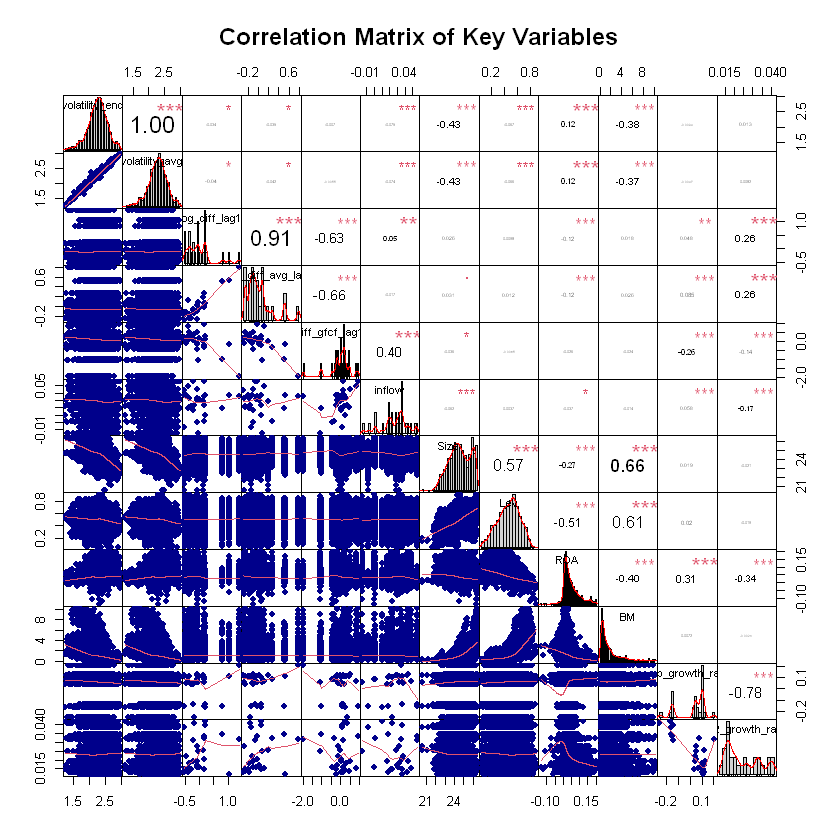

In [30]:
# Load the required library
library(PerformanceAnalytics)

# Select the main variables for the correlation matrix
# Focus on dependent variables, GFC measures, channels, and key controls
main_vars <- c("volatility_end", "volatility_avg", "log_diff_lag1", "log_diff_avg_lag1", 
               "diff_gfcf_lag1", "inflow",
               "Size", "Lev", "ROA", "BM", "gdp_growth_rate", "m2_growth_rate")

# Create a descriptive version of variable names for the plot
var_labels <- c("Volatility (EOQ)", "Volatility (Avg)", "VIX Change (EOQ, t-1)", 
                "VIX Change (Avg, t-1)", "GFCF Change (t-1)", "Capital Inflow",
                "Size", "Leverage", "ROA", "Book-to-Market", 
                "GDP Growth", "M2 Growth")

# Extract data as a regular data frame
corr_data <- as.data.frame(panel_data[, main_vars])

# Remove rows with any NA values
corr_data <- na.omit(corr_data)

# Set nice plotting parameters
par(bg = "white")

# Create the correlation plot with histograms
chart.Correlation(corr_data, 
                  histogram = TRUE,
                  method = "pearson",
                  pch = 19,
                  col = "darkblue",
                  main = "Correlation Matrix of Key Variables")

# Regression

1. Main

- $\text{Volatility}_{i,t} = \alpha + \beta \text{GFC}_{t-1} + \sum \text{Control} + \sum \text{FE} + \epsilon_{i,t}$

|Model|Volatility|GFC (lagged 1 period)|Firm|Macro|FE(S)|FE(Q)|
|:-|:-|:-|:-:|:-:|:-:|:-:|
|a (linear)|$\ln(\text{Volatility}_{\text{end of quarter }t})$|$\Delta\ln(\text{VIX}_{\text{end of quarter }t})$|⚪|⚪|⚪|⚪|
|a1|$\ln(\text{Volatility}_{\text{end of quarter }t})$|$\Delta\ln(\text{VIX}_{\text{end of quarter }t})$|⚪|⚪|⚪|⚪|

1. Robustness Test

|Model|Volatility|GFC (lagged 1 period)|Firm|Macro|FE(S)|FE(Q)|FE(I)|
|:-|:-|:-|:-:|:-:|:-:|:-:|:-:|
|a2|$\ln(\overline{\text{Volatility}_{\text{quarter }t}})$|$\Delta\ln(\overline{\text{VIX}_{\text{quarter }t}})$|⚪|⚪|⚪|⚪||
|a3|$\ln(\text{Volatility}_{\text{end of quarter }t})$|$\Delta\text{GFCF}_{\text{end of quarter }t}$|⚪|⚪|⚪|⚪||
|a4|$\ln(\text{Volatility}_{\text{end of quarter }t})$|$\Delta\ln(\text{VIX}_{\text{end of quarter }t})$|⚪|⚪|⚪|⚪|⚪|

3. Channel Verification: `GFC` >> Channel >> `Volatility`

    1. $\text{Channel}_{i,t} = \alpha + \beta \text{GFC}_{t-1} + \sum \text{Control} + \sum \text{FE} + \epsilon_{i,t}$
    2. $\text{Volatility}_{i,t} = \alpha + \beta \text{Channel}_{t} + \sum \text{Control} + \sum \text{FE} + \epsilon_{i,t}$

|Model|Volatility|Channel|GFC (lagged 1 period)|Firm|Macro|FE(S)|FE(Q)|
|:-|:-|:-|:-|:-:|:-:|:-:|:-:|
|b1|$\ln(\text{Volatility}_{\text{end of quarter }t})$|`inflow`|$\Delta\ln(\text{VIX}_{\text{end of quarter }t})$|⚪|⚪|⚪|⚪|
|b2|$\ln(\text{Volatility}_{\text{end of quarter }t})$|`tpu`|$\Delta\ln(\text{VIX}_{\text{end of quarter }t})$|⚪|⚪|⚪|⚪|

where:

||Channels|
|:-|:-:|
|`inflow`| |
|`tpu`| |

and

||Control Variables|
|:-|:-:|
|Firm|`Size`, `Lev`, `ROA`, `BM`, `Board`, `Top1`|
|Macro|`GDP Growth Rate`, `Money Supply Growth Rate`|

also

||Fixed Effects|
|:-|:-:|
|FE(S)|`Individual (stock)`|
|FE(Q)|`Quarter`|
|FE(P)|`Province`|
|FE(I)|`Industry`|

## Main

### Model a

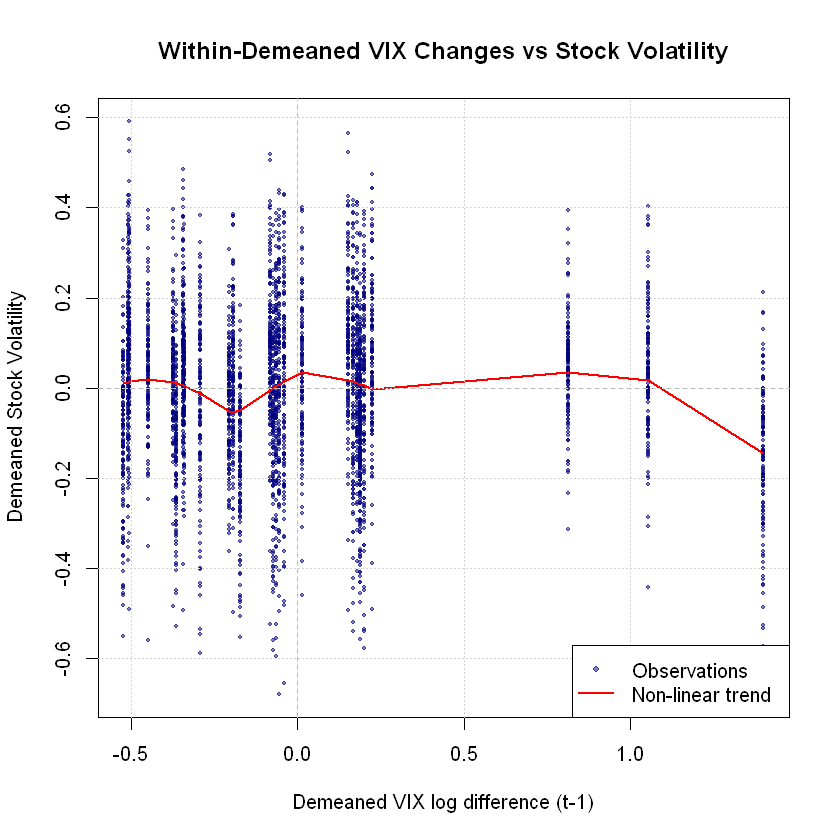

In [31]:
# Apply within-transformation to create demeaned variables
# This removes individual fixed effects by subtracting the individual-specific means

# Create a copy of the data for demeaning
panel_within <- panel_data

# Calculate demeaned variables (within transformation)
panel_within$volatility_end_demeaned <- with(panel_within, 
                                            volatility_end - ave(volatility_end, stkcd))
panel_within$log_diff_lag1_demeaned <- with(panel_within, 
                                           log_diff_lag1 - ave(log_diff_lag1, stkcd))

# Convert panel data objects to regular vectors for plotting
x_values <- as.numeric(panel_within$log_diff_lag1_demeaned)
y_values <- as.numeric(panel_within$volatility_end_demeaned)

# Create scatter plot of demeaned variables
par(bg="white", mar=c(5, 4, 4, 2) + 0.1)

# Basic scatter plot
plot(x_values, y_values,
     pch = 20, col = adjustcolor("navy", alpha.f = 0.5),
     xlab = "Demeaned VIX log difference (t-1)",
     ylab = "Demeaned Stock Volatility",
     main = "Within-Demeaned VIX Changes vs Stock Volatility",
     cex = 0.7)

# Add a vertical line at x = 0
abline(v = 0, lty = 2, col = "darkgray")
# Add a horizontal line at y = 0
abline(h = 0, lty = 2, col = "darkgray")

# Add a smoothed line to visualize the relationship
# Create a data frame for loess model
loess_data <- data.frame(
  x = x_values, 
  y = y_values
)
# Remove NA values for loess fitting
loess_data <- loess_data[!is.na(loess_data$x) & !is.na(loess_data$y), ]
smooth_line <- loess(y ~ x, data = loess_data, span = 0.5)

# Sort the data for smooth line plotting
sorted_data <- loess_data[order(loess_data$x),]
# Predict using the sorted data
smooth_pred <- predict(smooth_line, newdata = sorted_data)

# Plot the smooth line
lines(sorted_data$x, smooth_pred, col = "red", lwd = 2)

# Add grid for better readability
grid()

# Add a legend
legend("bottomright", 
       legend = c("Observations", "Non-linear trend"),
       col = c(adjustcolor("navy", alpha.f = 0.5), "red"),
       pch = c(20, NA), 
       lty = c(NA, 1),
       lwd = c(NA, 2))

In [32]:
library(plm)

# Run model with individual fixed effects and quarter dummies
model_a <- plm(volatility_end ~ log_diff_lag1 + Size + Lev + ROA + BM + Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
             data = panel_data,
             model = "within", 
             effect = "individual")

# Display regression results
summary(model_a)

# Get robust standard errors for both models
library(lmtest)
library(sandwich)
cat("\nRobust standard errors for two-way fixed effects model:\n")
coeftest(model_a, vcov = vcovHC(model_a, type = "HC1"))

Oneway (individual) effect Within Model

Call:
plm(formula = volatility_end ~ log_diff_lag1 + Size + Lev + ROA + 
    BM + Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
    data = panel_data, effect = "individual", model = "within")

Balanced Panel: n = 127, T = 7, N = 3556

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.5965455 -0.1004148  0.0052385  0.1037313  0.5351314 

Coefficients:
                  Estimate Std. Error  t-value  Pr(>|t|)    
log_diff_lag1   -0.0151140  0.0079899  -1.8916  0.058624 .  
Size            -0.0609260  0.0074911  -8.1331 5.794e-16 ***
Lev              0.2163969  0.0521066   4.1530 3.362e-05 ***
ROA              0.2762204  0.1134150   2.4355  0.014923 *  
BM              -0.0832410  0.0042846 -19.4279 < 2.2e-16 ***
Board            0.1119885  0.0339954   3.2942  0.000997 ***
Top1             0.0090198  0.0610592   0.1477  0.882571    
quarter2         0.0555594  0.0353540   1.5715  0.116155    
quarter3         0.0388


Robust standard errors for two-way fixed effects model:



t test of coefficients:

                  Estimate Std. Error t value  Pr(>|t|)    
log_diff_lag1   -0.0151140  0.0056294 -2.6848  0.007292 ** 
Size            -0.0609260  0.0206260 -2.9538  0.003160 ** 
Lev              0.2163969  0.1447689  1.4948  0.135066    
ROA              0.2762204  0.2597737  1.0633  0.287716    
BM              -0.0832410  0.0108174 -7.6951 1.837e-14 ***
Board            0.1119885  0.0728922  1.5364  0.124543    
Top1             0.0090198  0.1771731  0.0509  0.959401    
quarter2         0.0555594  0.0196834  2.8227  0.004790 ** 
quarter3         0.0388988  0.0186890  2.0814  0.037474 *  
quarter4         0.0518632  0.0242569  2.1381  0.032581 *  
gdp_growth_rate -0.1146843  0.0568543 -2.0172  0.043757 *  
m2_growth_rate   1.6503844  0.6494515  2.5412  0.011091 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### Model a1

#### Panel Regression

In [33]:
library(plm)

# Run model with individual fixed effects and quarter dummies
model_a1 <- plm(volatility_end ~ log_diff_lag1 + I(log_diff_lag1^2) + I(log_diff_lag1^3) + Size + Lev + ROA + BM + Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
             data = panel_data, 
             model = "within", 
             effect = "individual")

# Display regression results
summary(model_a1)

# Get robust standard errors for both models
library(lmtest)
library(sandwich)
cat("\nRobust standard errors for two-way fixed effects model:\n")
coeftest(model_a1, vcov = vcovHC(model_a1, type = "HC1"))

Oneway (individual) effect Within Model

Call:
plm(formula = volatility_end ~ log_diff_lag1 + I(log_diff_lag1^2) + 
    I(log_diff_lag1^3) + Size + Lev + ROA + BM + Board + Top1 + 
    quarter + gdp_growth_rate + m2_growth_rate, data = panel_data, 
    effect = "individual", model = "within")

Balanced Panel: n = 127, T = 7, N = 3556

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.6217185 -0.0991969  0.0058653  0.0999832  0.5248352 

Coefficients:
                     Estimate Std. Error  t-value  Pr(>|t|)    
log_diff_lag1       0.0932767  0.0134940   6.9125 5.660e-12 ***
I(log_diff_lag1^2)  0.1821398  0.0295478   6.1642 7.908e-10 ***
I(log_diff_lag1^3) -0.2458908  0.0278714  -8.8223 < 2.2e-16 ***
Size               -0.0493606  0.0075881  -6.5050 8.903e-11 ***
Lev                 0.2047429  0.0514560   3.9790 7.065e-05 ***
ROA                 0.2522455  0.1118610   2.2550 0.0241970 *  
BM                 -0.0775472  0.0042756 -18.1371 < 2.2e-16 ***
Board        


Robust standard errors for two-way fixed effects model:



t test of coefficients:

                     Estimate Std. Error t value  Pr(>|t|)    
log_diff_lag1       0.0932767  0.0097536  9.5633 < 2.2e-16 ***
I(log_diff_lag1^2)  0.1821398  0.0234097  7.7805 9.498e-15 ***
I(log_diff_lag1^3) -0.2458908  0.0263522 -9.3309 < 2.2e-16 ***
Size               -0.0493606  0.0201392 -2.4510   0.01430 *  
Lev                 0.2047429  0.1430145  1.4316   0.15234    
ROA                 0.2522455  0.2562680  0.9843   0.32504    
BM                 -0.0775472  0.0109104 -7.1077 1.430e-12 ***
Board               0.1053785  0.0735071  1.4336   0.15178    
Top1               -0.0059316  0.1785356 -0.0332   0.97350    
quarter2           -0.0374078  0.0214051 -1.7476   0.08062 .  
quarter3           -0.0215952  0.0184819 -1.1685   0.24271    
quarter4           -0.0328498  0.0240270 -1.3672   0.17165    
gdp_growth_rate     0.4487606  0.0992875  4.5198 6.399e-06 ***
m2_growth_rate      4.0535310  0.6680435  6.0678 1.439e-09 ***
---
Signif. codes:  0 '***' 0

In [34]:
# Test for nonlinearity by comparing linear and nonlinear models
library(lmtest)

# Test if adding nonlinear terms improves the model
waldtest(model_a, model_a1)

# Print message explaining the test
cat("This test compares the linear model to a model with squared and cubed terms of log_diff_lag1.\n")
cat("A significant p-value indicates that nonlinear terms should be included.\n")

,Res.Df,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>
1,3417,NA,NA,NA
2,3415,2,99.26908,2.779673e-22


This test compares the linear model to a model with squared and cubed terms of log_diff_lag1.
A significant p-value indicates that nonlinear terms should be included.


In [35]:
# Load the xtable package for creating LaTeX tables
library(xtable)

# Run the Wald test and store the result
wald_result <- waldtest(model_a, model_a1)

# Create a LaTeX table from the test result
wald_table <- xtable(wald_result, 
                    caption = "Wald Test for Nonlinearity",
                    label = "tab:waldtest")

# Print the table in LaTeX format
print(wald_table, 
      include.rownames = TRUE,
      caption.placement = "top",
      hline.after = c(-1, 0, nrow(wald_result)),
      comment = FALSE)

\begin{table}[ht]
\centering
\caption{Wald Test for Nonlinearity} 
\label{tab:waldtest}
\begin{tabular}{lrrrr}
  \hline
 & Res.Df & Df & Chisq & Pr($>$Chisq) \\ 
  \hline
1 & 3417 &  &  &  \\ 
  2 & 3415 & 2 & 99.27 & 0.0000 \\ 
   \hline
\end{tabular}
\end{table}


In [36]:
# Load the stargazer package
library(stargazer)

# Create a list of the models to include in the table
models <- list(model_a, model_a1)

# Define custom coefficient names for the variables we want to show
coef_names <- c("GFC", "GFC$^2$", "GFC$^3$")

# Create the LaTeX table
stargazer(models, 
          title = "Regression Results: Effects of Global Financial Cycle on Stock Volatility",
          column.labels = c("(a)", "(a1)"),
          model.numbers = FALSE,  # This prevents duplicate numbering
          covariate.labels = coef_names,
          dep.var.labels = "Volatility",
          model.names = FALSE,
          digits = 3,
          header = FALSE,
          omit = c("Size", "Lev", "ROA", "BM", "Board", "Top1", "quarter", "gdp_growth_rate", "m2_growth_rate"),
          omit.stat = c("ser"),
          add.lines = list(
              c("Firm Controls", "YES", "YES"),
              c("Macro Controls", "YES", "YES"),
              c("Quarter FE", "YES", "YES"),
              c("Stock FE", "YES", "YES")
          ),
          notes = "Robust standard errors in parentheses",
          notes.align = "r",
          type = "latex")


\begin{table}[!htbp] \centering 
  \caption{Regression Results: Effects of Global Financial Cycle on Stock Volatility} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{2}{c}{\textit{Dependent variable:}} \\ 
\cline{2-3} 
\\[-1.8ex] & \multicolumn{2}{c}{Volatility} \\ 
 & (a) & (a1) \\ 
\hline \\[-1.8ex] 
 GFC & $-$0.015$^{*}$ & 0.093$^{***}$ \\ 
  & (0.008) & (0.013) \\ 
  & & \\ 
 GFC$^2$ &  & 0.182$^{***}$ \\ 
  &  & (0.030) \\ 
  & & \\ 
 GFC$^3$ &  & $-$0.246$^{***}$ \\ 
  &  & (0.028) \\ 
  & & \\ 
\hline \\[-1.8ex] 
Firm Controls & YES & YES \\ 
Macro Controls & YES & YES \\ 
Quarter FE & YES & YES \\ 
Stock FE & YES & YES \\ 
Observations & 3,556 & 3,556 \\ 
R$^{2}$ & 0.136 & 0.160 \\ 
Adjusted R$^{2}$ & 0.101 & 0.126 \\ 
F Statistic & 44.785$^{***}$ (df = 12; 3417) & 46.571$^{***}$ (df = 14; 3415) \\ 
\hline 
\hline \\[-1.8ex] 
\textit{Note:}  & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\ 
 

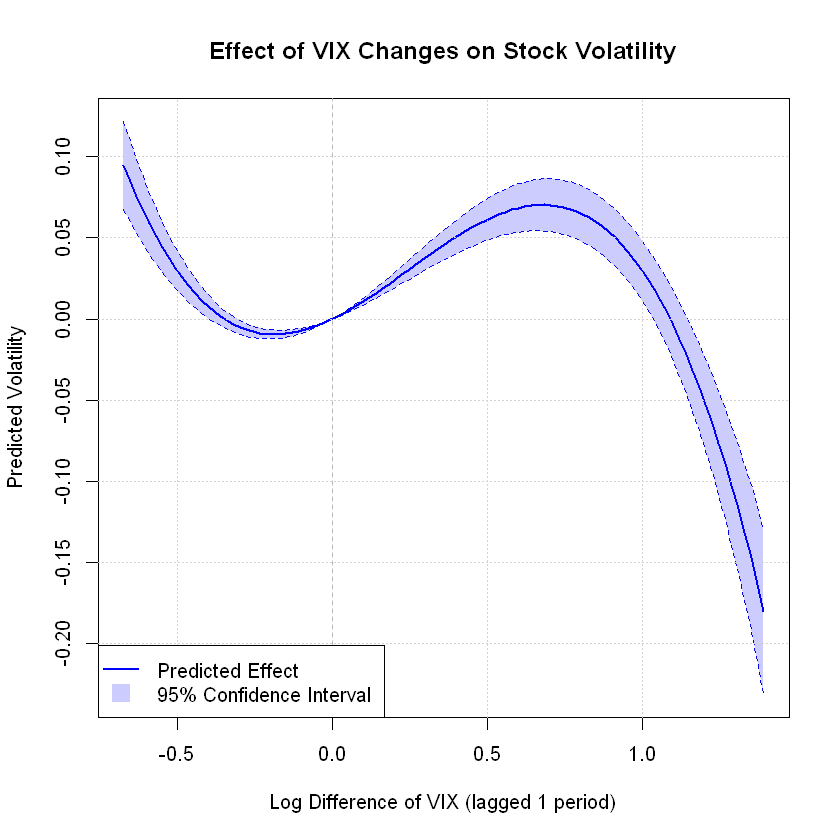

In [40]:
par(bg="white", mar=c(5, 4, 4, 2) + 0.1)

# Extract coefficients for log_diff_lag1 and its higher order terms
coefficients <- coef(model_a1)
b1 <- coefficients["log_diff_lag1"]
b2 <- coefficients["I(log_diff_lag1^2)"]
b3 <- coefficients["I(log_diff_lag1^3)"]

# Use the range from the original gfc_indicators dataframe
min_value <- min(gfc_indicators$log_diff_lag1, na.rm = TRUE)
max_value <- max(gfc_indicators$log_diff_lag1, na.rm = TRUE)
log_diff_values <- seq(min_value, max_value, length.out = 100)

# Calculate predicted volatility for each value (partial effect, ignoring other variables)
predicted_volatility <- b1 * log_diff_values + 
                        b2 * log_diff_values^2 + 
                        b3 * log_diff_values^3

# Get the variance-covariance matrix for the coefficients
vcov_matrix <- vcovHC(model_a1, type = "HC1") # Using robust variance-covariance matrix

# Extract the rows/columns for our parameters of interest
param_indices <- which(names(coefficients) %in% c("log_diff_lag1", "I(log_diff_lag1^2)", "I(log_diff_lag1^3)"))
vcov_subset <- vcov_matrix[param_indices, param_indices]

# Calculate standard error for each prediction point
se_predictions <- numeric(length(log_diff_values))
for (i in 1:length(log_diff_values)) {
    # Create X matrix for this prediction point
    X_i <- c(log_diff_values[i], log_diff_values[i]^2, log_diff_values[i]^3)
    
    # Calculate variance of prediction
    se_predictions[i] <- sqrt(t(X_i) %*% vcov_subset %*% X_i)
}

# Calculate confidence intervals (95%)
confidence_level <- 0.95
t_value <- qt((1 + confidence_level) / 2, df = df.residual(model_a1))
upper_ci <- predicted_volatility + t_value * se_predictions
lower_ci <- predicted_volatility - t_value * se_predictions

# Create the plot
plot(log_diff_values, predicted_volatility, type = "l", lwd = 2, col = "blue",
     xlab = "Log Difference of VIX (lagged 1 period)",
     ylab = "Predicted Volatility",
     main = "Effect of VIX Changes on Stock Volatility",
     ylim = range(c(lower_ci, upper_ci)))

# Add confidence intervals
polygon(c(log_diff_values, rev(log_diff_values)), 
        c(lower_ci, rev(upper_ci)), 
        col = rgb(0, 0, 1, 0.2), border = NA)

# Add the CI lines
lines(log_diff_values, upper_ci, lty = 2, col = "blue")
lines(log_diff_values, lower_ci, lty = 2, col = "blue")

# Add a vertical line at x = 0 for reference
abline(v = 0, lty = 2, col = "darkgray")

# Add a grid for better readability
grid()

# Add a legend
legend("bottomleft", 
       legend = c("Predicted Effect", "95% Confidence Interval"),
       col = c("blue", rgb(0, 0, 1, 0.2)),
       lty = c(1, 0), 
       pch = c(NA, 15),
       pt.bg = rgb(0, 0, 1, 0.2),
       lwd = c(2, NA),
       pt.cex = 2,
       bg = "white")

#### Testing

- Hausman

In [41]:
# First estimate a random effects version of model_a1
model_a1_re <- plm(volatility_end ~ log_diff_lag1 + I(log_diff_lag1^2) + I(log_diff_lag1^3) +  
                   Size + Lev + ROA + BM + Board + Top1 + quarter + 
                   gdp_growth_rate + m2_growth_rate, 
                   data = panel_data, 
                   model = "random")

# Perform Hausman test
hausman_test <- phtest(model_a1, model_a1_re)

# Print the results
print(hausman_test)


	Hausman Test

data:  volatility_end ~ log_diff_lag1 + I(log_diff_lag1^2) + I(log_diff_lag1^3) +  ...
chisq = 50.831, df = 14, p-value = 4.429e-06
alternative hypothesis: one model is inconsistent



In [42]:
# Create a data frame with the Hausman test results
hausman_df <- data.frame(
    Statistic = hausman_test$statistic,
    df = hausman_test$parameter,
    p.value = hausman_test$p.value
)
rownames(hausman_df) <- "Hausman Test"

# Convert to LaTeX table
hausman_table <- xtable(hausman_df,
                                                caption = "Hausman Test Results: Fixed vs. Random Effects",
                                                label = "tab:hausman")

# Print the table in LaTeX format
print(hausman_table,
            include.rownames = TRUE,
            caption.placement = "top",
            comment = FALSE)

\begin{table}[ht]
\centering
\caption{Hausman Test Results: Fixed vs. Random Effects} 
\label{tab:hausman}
\begin{tabular}{rrrr}
  \hline
 & Statistic & df & p.value \\ 
  \hline
Hausman Test & 50.83 &  14 & 0.00 \\ 
   \hline
\end{tabular}
\end{table}


- Residual Plots

In [43]:
# Extract fitted values and residuals
fitted_values_model_a1 <- as.numeric(fitted(model_a1))
residuals_model_a1 <- as.numeric(residuals(model_a1))

- Fitted vs Residual Plot

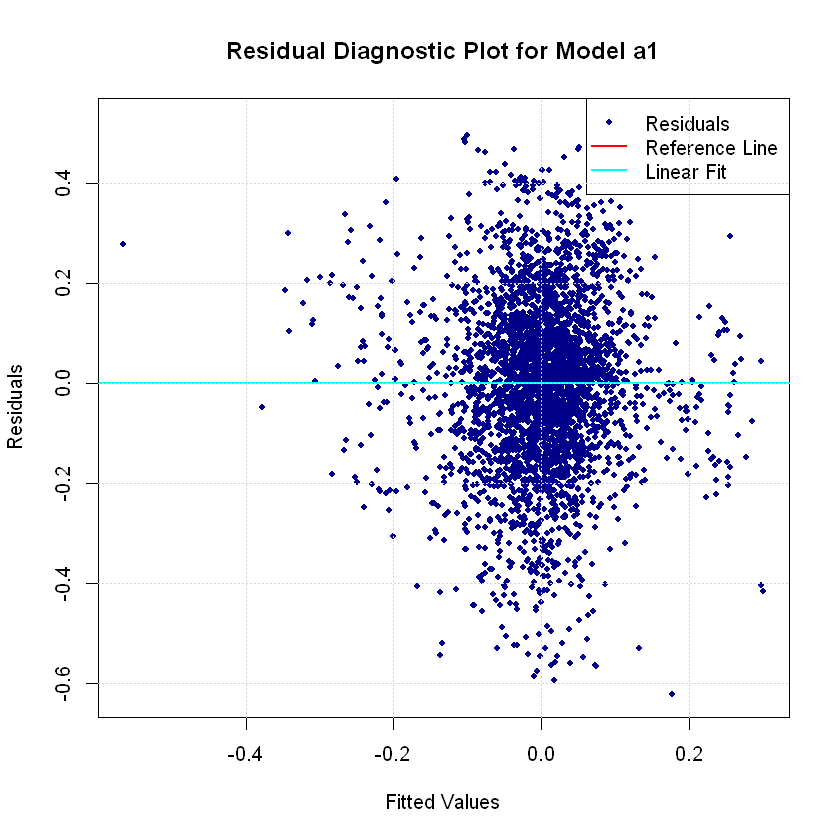

In [44]:
par(bg="white")

# Create a scatter plot of fitted values vs residuals
plot(fitted_values_model_a1, residuals_model_a1, 
    pch = 20, col = "darkblue",
    xlab = "Fitted Values", ylab = "Residuals",
    main = "Residual Diagnostic Plot for Model a1")

# Add a horizontal line at y = 0
abline(h = 0, col = "red", lwd = 2)

# Add a linear fitted line instead of a smoothed line
lm_fit <- lm(residuals_model_a1 ~ fitted_values_model_a1)
abline(lm_fit, col = "cyan", lwd = 2)

# Add a legend
legend("topright", 
      legend = c("Residuals", "Reference Line", "Linear Fit"),
      col = c("darkblue", "red", "cyan"),
      pch = c(20, NA, NA), 
      lty = c(NA, 1, 1),
      lwd = c(NA, 2, 2))

# Add grid for better readability
grid()


## Robustness Test

### Model a2

> Robustness verification of Model a1 by changing $\text{Volatility}$ and $\text{GFC}$ from quarter-end data to quarterly-averaged data.

#### Panel Regression

In [45]:
library(plm)

# Run model with individual fixed effects and quarter dummies
model_a2 <- plm(volatility_avg ~ log_diff_avg_lag1 + I(log_diff_avg_lag1^2) + I(log_diff_avg_lag1^3) + Size + Lev + ROA + BM + Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
             data = panel_data, 
             model = "within", 
             effect = "individual")

# Display regression results
summary(model_a2)

# Get robust standard errors for both models
library(lmtest)
library(sandwich)
cat("\nRobust standard errors for two-way fixed effects model:\n")
coeftest(model_a2, vcov = vcovHC(model_a2, type = "HC1"))

Oneway (individual) effect Within Model

Call:
plm(formula = volatility_avg ~ log_diff_avg_lag1 + I(log_diff_avg_lag1^2) + 
    I(log_diff_avg_lag1^3) + Size + Lev + ROA + BM + Board + 
    Top1 + quarter + gdp_growth_rate + m2_growth_rate, data = panel_data, 
    effect = "individual", model = "within")

Balanced Panel: n = 127, T = 7, N = 3556

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.6306385 -0.0962135  0.0073421  0.0998254  0.5358076 

Coefficients:
                         Estimate Std. Error  t-value  Pr(>|t|)    
log_diff_avg_lag1       0.0996119  0.0207125   4.8093 1.580e-06 ***
I(log_diff_avg_lag1^2)  0.4882712  0.0908303   5.3756 8.143e-08 ***
I(log_diff_avg_lag1^3) -1.1672533  0.1404392  -8.3115 < 2.2e-16 ***
Size                   -0.0626009  0.0074389  -8.4154 < 2.2e-16 ***
Lev                     0.2348138  0.0513208   4.5754 4.922e-06 ***
ROA                     0.2605508  0.1116857   2.3329 0.0197115 *  
BM                     -0.0749686  0.


Robust standard errors for two-way fixed effects model:



t test of coefficients:

                         Estimate Std. Error  t value  Pr(>|t|)    
log_diff_avg_lag1       0.0996119  0.0115621   8.6154 < 2.2e-16 ***
I(log_diff_avg_lag1^2)  0.4882712  0.0370581  13.1758 < 2.2e-16 ***
I(log_diff_avg_lag1^3) -1.1672533  0.1045289 -11.1668 < 2.2e-16 ***
Size                   -0.0626009  0.0205734  -3.0428 0.0023617 ** 
Lev                     0.2348138  0.1427092   1.6454 0.0999791 .  
ROA                     0.2605508  0.2519094   1.0343 0.3010675    
BM                     -0.0749686  0.0107369  -6.9823 3.474e-12 ***
Board                   0.1158795  0.0741704   1.5623 0.1183000    
Top1                    0.0051173  0.1774046   0.0288 0.9769897    
quarter2               -0.1053920  0.0259855  -4.0558 5.108e-05 ***
quarter3               -0.0859839  0.0228152  -3.7687 0.0001669 ***
quarter4               -0.0956084  0.0284504  -3.3605 0.0007865 ***
gdp_growth_rate         0.6184805  0.1169520   5.2883 1.312e-07 ***
m2_growth_rate        

#### Testing

- Residual Plots

In [46]:
# Extract fitted values and residuals
fitted_values_model_a2 <- as.numeric(fitted(model_a2))
residuals_model_a2 <- as.numeric(residuals(model_a2))

- Fitted vs Residual Plot

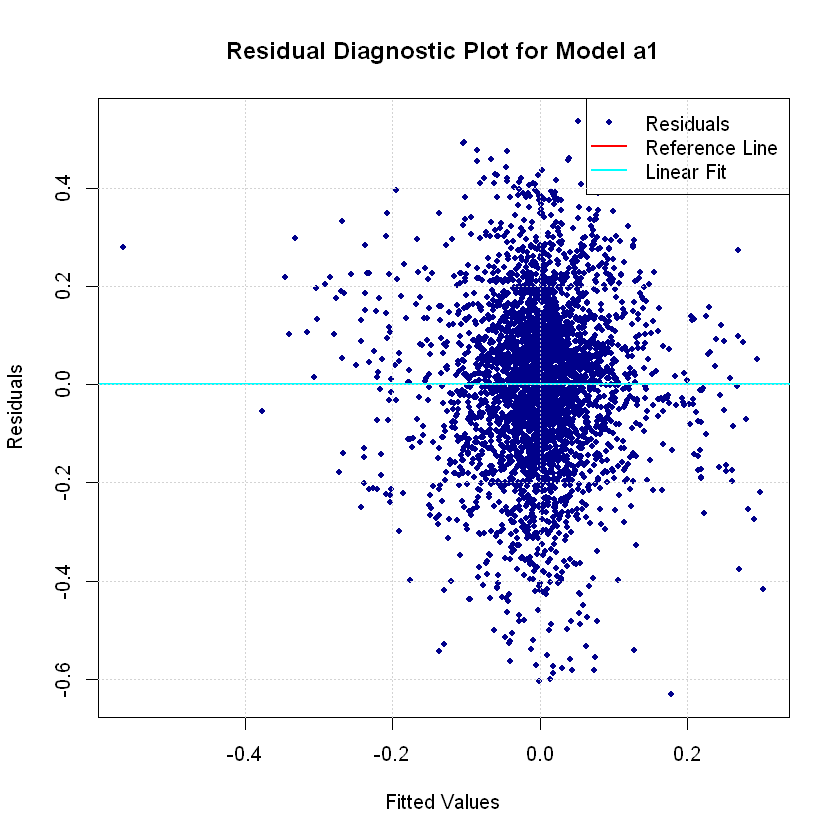

In [47]:
par(bg="white")

# Create a scatter plot of fitted values vs residuals
plot(fitted_values_model_a2, residuals_model_a2, 
    pch = 20, col = "darkblue",
    xlab = "Fitted Values", ylab = "Residuals",
    main = "Residual Diagnostic Plot for Model a1")

# Add a horizontal line at y = 0
abline(h = 0, col = "red", lwd = 2)

# Add a linear fitted line instead of a smoothed line
lm_fit <- lm(residuals_model_a2 ~ fitted_values_model_a2)
abline(lm_fit, col = "cyan", lwd = 2)

# Add a legend
legend("topright", 
      legend = c("Residuals", "Reference Line", "Linear Fit"),
      col = c("darkblue", "red", "cyan"),
      pch = c(20, NA, NA), 
      lty = c(NA, 1, 1),
      lwd = c(NA, 2, 2))

# Add grid for better readability
grid()


### Model a3

> Robustness verification of Model a1 by changing the proxy for $\text{GFC}$ from VIX-based data to GFCF.

#### Panel Regression

In [48]:
library(plm)

# Run model with individual fixed effects and quarter dummies
model_a3 <- plm(volatility_end ~ diff_gfcf_lag1 + I(diff_gfcf_lag1^2) + I(diff_gfcf_lag1^3) + Size + Lev + ROA + BM + Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
             data = panel_data, 
             model = "within", 
             effect = "individual")

# Display regression results
summary(model_a3)

# Get robust standard errors for both models
library(lmtest)
library(sandwich)
cat("\nRobust standard errors for two-way fixed effects model:\n")
coeftest(model_a3, vcov = vcovHC(model_a3, type = "HC1"))

Oneway (individual) effect Within Model

Call:
plm(formula = volatility_end ~ diff_gfcf_lag1 + I(diff_gfcf_lag1^2) + 
    I(diff_gfcf_lag1^3) + Size + Lev + ROA + BM + Board + Top1 + 
    quarter + gdp_growth_rate + m2_growth_rate, data = panel_data, 
    effect = "individual", model = "within")

Balanced Panel: n = 127, T = 7, N = 3556

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.6199819 -0.0978502  0.0051083  0.1005591  0.5141257 

Coefficients:
                      Estimate Std. Error  t-value  Pr(>|t|)    
diff_gfcf_lag1      -0.1020794  0.0090766 -11.2464 < 2.2e-16 ***
I(diff_gfcf_lag1^2) -0.0470302  0.0112844  -4.1677 3.153e-05 ***
I(diff_gfcf_lag1^3)  0.0363553  0.0070453   5.1603 2.607e-07 ***
Size                -0.0417731  0.0078299  -5.3351 1.017e-07 ***
Lev                  0.2078062  0.0506278   4.1046 4.145e-05 ***
ROA                  0.2122839  0.1098736   1.9321 0.0534330 .  
BM                  -0.0739799  0.0042128 -17.5606 < 2.2e-16 ***
Bo


Robust standard errors for two-way fixed effects model:



t test of coefficients:

                      Estimate Std. Error  t value  Pr(>|t|)    
diff_gfcf_lag1      -0.1020794  0.0085341 -11.9613 < 2.2e-16 ***
I(diff_gfcf_lag1^2) -0.0470302  0.0153991  -3.0541  0.002275 ** 
I(diff_gfcf_lag1^3)  0.0363553  0.0071712   5.0696 4.198e-07 ***
Size                -0.0417731  0.0190933  -2.1878  0.028749 *  
Lev                  0.2078062  0.1393331   1.4914  0.135940    
ROA                  0.2122839  0.2503573   0.8479  0.396540    
BM                  -0.0739799  0.0109658  -6.7464 1.773e-11 ***
Board                0.0954825  0.0723171   1.3203  0.186813    
Top1                -0.0148956  0.1783602  -0.0835  0.933448    
quarter2            -0.2331633  0.0430663  -5.4141 6.587e-08 ***
quarter3            -0.1992840  0.0357367  -5.5765 2.645e-08 ***
quarter4            -0.2574340  0.0477486  -5.3914 7.464e-08 ***
gdp_growth_rate      0.9813137  0.1569163   6.2537 4.504e-10 ***
m2_growth_rate       2.2884000  0.8886936   2.5750  0.010065 *  

#### Testing

- Residual Plots

In [49]:
# Extract fitted values and residuals
fitted_values_model_a3 <- as.numeric(fitted(model_a3))
residuals_model_a3 <- as.numeric(residuals(model_a3))

- Fitted vs Residual Plot

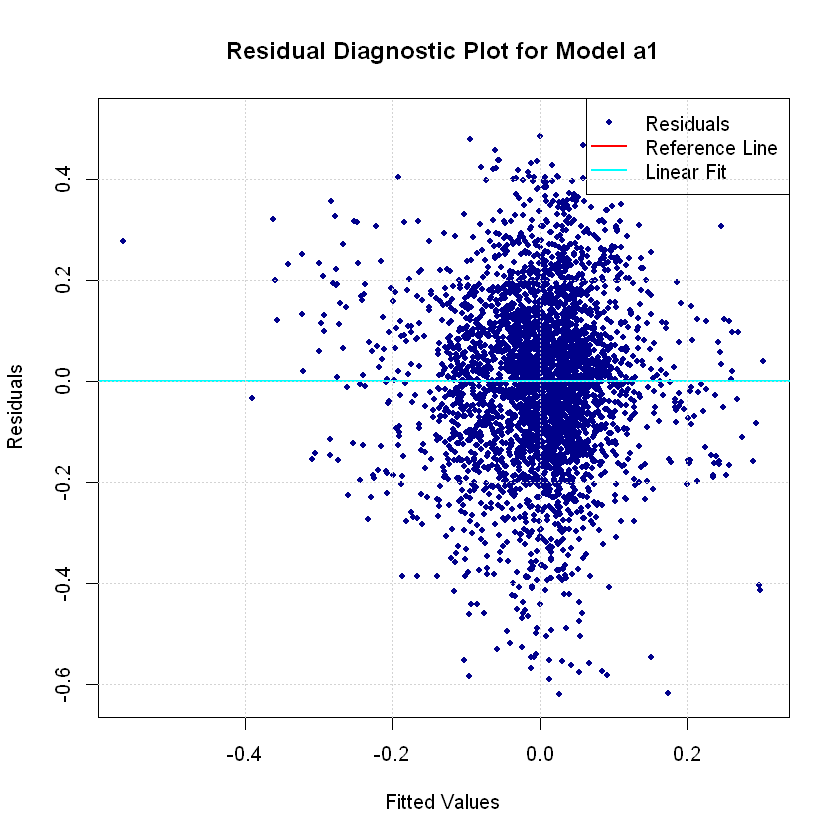

In [50]:
par(bg="white")

# Create a scatter plot of fitted values vs residuals
plot(fitted_values_model_a3, residuals_model_a3, 
    pch = 20, col = "darkblue",
    xlab = "Fitted Values", ylab = "Residuals",
    main = "Residual Diagnostic Plot for Model a1")

# Add a horizontal line at y = 0
abline(h = 0, col = "red", lwd = 2)

# Add a linear fitted line instead of a smoothed line
lm_fit <- lm(residuals_model_a3 ~ fitted_values_model_a3)
abline(lm_fit, col = "cyan", lwd = 2)

# Add a legend
legend("topright", 
      legend = c("Residuals", "Reference Line", "Linear Fit"),
      col = c("darkblue", "red", "cyan"),
      pch = c(20, NA, NA), 
      lty = c(NA, 1, 1),
      lwd = c(NA, 2, 2))

# Add grid for better readability
grid()


### Model a4

> Robustness verification of Model a1 by controlling industrial and provincial fixed effects.

#### Panel Regression

In [51]:
library(plm)

# Run model with individual fixed effects and quarter dummies
model_a4 <- plm(volatility_end ~ log_diff_avg_lag1 + I(log_diff_avg_lag1^2) + I(log_diff_avg_lag1^3) + Size + Lev + ROA + BM + Board + Top1 + quarter + ind + gdp_growth_rate + m2_growth_rate, 
             data = panel_data, 
             model = "within", 
             effect = "individual")

# Display regression results
summary(model_a4)

# Get robust standard errors for both models
library(lmtest)
library(sandwich)
cat("\nRobust standard errors for two-way fixed effects model:\n")
coeftest(model_a4, vcov = vcovHC(model_a4, type = "HC1"))

Oneway (individual) effect Within Model

Call:
plm(formula = volatility_end ~ log_diff_avg_lag1 + I(log_diff_avg_lag1^2) + 
    I(log_diff_avg_lag1^3) + Size + Lev + ROA + BM + Board + 
    Top1 + quarter + ind + gdp_growth_rate + m2_growth_rate, 
    data = panel_data, effect = "individual", model = "within")

Balanced Panel: n = 127, T = 7, N = 3556

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.6276770 -0.0969830  0.0067972  0.0987419  0.5407385 

Coefficients: (3 dropped because of singularities)
                         Estimate Std. Error  t-value  Pr(>|t|)    
log_diff_avg_lag1       0.1123553  0.0207214   5.4222 6.297e-08 ***
I(log_diff_avg_lag1^2)  0.5234502  0.0908941   5.7589 9.216e-09 ***
I(log_diff_avg_lag1^3) -1.2287868  0.1405517  -8.7426 < 2.2e-16 ***
Size                   -0.0539088  0.0080139  -6.7269 2.025e-11 ***
Lev                     0.2127531  0.0518123   4.1062 4.116e-05 ***
ROA                     0.2627266  0.1118456   2.3490 0.018880


Robust standard errors for two-way fixed effects model:



t test of coefficients:

                        Estimate Std. Error  t value  Pr(>|t|)    
log_diff_avg_lag1       0.112355   0.011462   9.8027 < 2.2e-16 ***
I(log_diff_avg_lag1^2)  0.523450   0.040895  12.7999 < 2.2e-16 ***
I(log_diff_avg_lag1^3) -1.228787   0.111046 -11.0655 < 2.2e-16 ***
Size                   -0.053909   0.023649  -2.2796 0.0226937 *  
Lev                     0.212753   0.145401   1.4632 0.1434996    
ROA                     0.262727   0.257263   1.0212 0.3072147    
BM                     -0.077353   0.011013  -7.0235 2.601e-12 ***
Board                   0.116037   0.074476   1.5580 0.1193180    
Top1                    0.016366   0.188601   0.0868 0.9308539    
quarter2               -0.126174   0.027181  -4.6420 3.580e-06 ***
quarter3               -0.097764   0.023558  -4.1500 3.407e-05 ***
quarter4               -0.112574   0.029257  -3.8478 0.0001214 ***
indC18                  0.170581   0.039411   4.3282 1.546e-05 ***
indC26                  0.158839   0

In [52]:
# Load the stargazer package
library(stargazer)

# Create a list of the models to include in the table
models <- list(model_a2, model_a3, model_a4)

# Create the LaTeX table with improved variable naming
stargazer(models, 
          title = "Regression Results: Effects of Global Financial Cycle on Stock Volatility",
          column.labels = c("(a2)", "(a3)", "(a4)"),
          model.numbers = FALSE,
          dep.var.labels = "Volatility", # Consistent dependent variable name
          covariate.labels = c("GFC", "GFC$^2$", "GFC$^3$", 
                             "GFC", "GFC$^2$", "GFC$^3$"), # Standardized names for all GFC variables
          order = c("log_diff_avg_lag1", "I\\(log_diff_avg_lag1\\^2\\)", "I\\(log_diff_avg_lag1\\^3\\)",
                   "diff_gfcf_lag1", "I\\(diff_gfcf_lag1\\^2\\)", "I\\(diff_gfcf_lag1\\^3\\)"),
          model.names = FALSE,
          digits = 3,
          header = FALSE,
          omit = c("Size", "Lev", "ROA", "BM", "Board", "Top1", "quarter", "ind", "gdp_growth_rate", "m2_growth_rate"),
          omit.stat = c("ser"),
          add.lines = list(
                    c("Firm Controls", "YES", "YES", "YES"),
                    c("Macro Controls", "YES", "YES", "YES"),
                    c("Quarter FE", "YES", "YES", "YES"),
                    c("Stock FE", "YES", "YES", "YES"),
                    c("Industry FE", "NO", "NO", "YES")
            ),
          notes = "Robust standard errors in parentheses",
          notes.align = "r",
          type = "latex")


\begin{table}[!htbp] \centering 
  \caption{Regression Results: Effects of Global Financial Cycle on Stock Volatility} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{3}{c}{\textit{Dependent variable:}} \\ 
\cline{2-4} 
\\[-1.8ex] & Volatility & \multicolumn{2}{c}{volatility\_end} \\ 
 & (a2) & (a3) & (a4) \\ 
\hline \\[-1.8ex] 
 GFC & 0.100$^{***}$ &  & 0.112$^{***}$ \\ 
  & (0.021) &  & (0.021) \\ 
  & & & \\ 
 GFC$^2$ & 0.488$^{***}$ &  & 0.523$^{***}$ \\ 
  & (0.091) &  & (0.091) \\ 
  & & & \\ 
 GFC$^3$ & $-$1.167$^{***}$ &  & $-$1.229$^{***}$ \\ 
  & (0.140) &  & (0.141) \\ 
  & & & \\ 
 GFC &  & $-$0.102$^{***}$ &  \\ 
  &  & (0.009) &  \\ 
  & & & \\ 
 GFC$^2$ &  & $-$0.047$^{***}$ &  \\ 
  &  & (0.011) &  \\ 
  & & & \\ 
 GFC$^3$ &  & 0.036$^{***}$ &  \\ 
  &  & (0.007) &  \\ 
  & & & \\ 
\hline \\[-1.8ex] 
Firm Controls & YES & YES & YES \\ 
Macro Controls & YES & YES & YES \\ 
Quarter FE & YES & YES & YES \\ 
Stoc

## Channel Verification

### Model b

> `GFC` >> `International Capital Inflow` >> `Volatility`

- `GFC` >> `International Capital Inflow`

In [53]:
library(plm)

# Run model with individual fixed effects and quarter dummies
model_b_1 <- plm(inflow ~ log_diff_lag1 + I(log_diff_lag1^2) + I(log_diff_lag1^3) + Size + Lev + ROA + BM + Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
             data = panel_data, 
             model = "within", 
             effect = "individual")

# Display regression results
summary(model_b_1)

# Get robust standard errors for both models
library(lmtest)
library(sandwich)
cat("\nRobust standard errors for two-way fixed effects model:\n")
coeftest(model_b_1, vcov = vcovHC(model_b_1, type = "HC1"))

Oneway (individual) effect Within Model

Call:
plm(formula = inflow ~ log_diff_lag1 + I(log_diff_lag1^2) + I(log_diff_lag1^3) + 
    Size + Lev + ROA + BM + Board + Top1 + quarter + gdp_growth_rate + 
    m2_growth_rate, data = panel_data, effect = "individual", 
    model = "within")

Balanced Panel: n = 127, T = 7, N = 3556

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.0515899 -0.0089303  0.0022444  0.0093117  0.0268450 

Coefficients:
                      Estimate  Std. Error  t-value  Pr(>|t|)    
log_diff_lag1      -0.00662648  0.00115073  -5.7585 9.238e-09 ***
I(log_diff_lag1^2) -0.03733641  0.00251976 -14.8175 < 2.2e-16 ***
I(log_diff_lag1^3)  0.03215341  0.00237680  13.5280 < 2.2e-16 ***
Size               -0.00728211  0.00064710 -11.2535 < 2.2e-16 ***
Lev                 0.01589331  0.00438804   3.6220 0.0002966 ***
ROA                -0.00352681  0.00953922  -0.3697 0.7116164    
BM                 -0.00031368  0.00036461  -0.8603 0.3896791    
Board


Robust standard errors for two-way fixed effects model:



t test of coefficients:

                      Estimate  Std. Error   t value  Pr(>|t|)    
log_diff_lag1      -0.00662648  0.00015502  -42.7465 < 2.2e-16 ***
I(log_diff_lag1^2) -0.03733641  0.00053544  -69.7301 < 2.2e-16 ***
I(log_diff_lag1^3)  0.03215341  0.00053436   60.1723 < 2.2e-16 ***
Size               -0.00728211  0.00076694   -9.4950 < 2.2e-16 ***
Lev                 0.01589331  0.00543591    2.9238  0.003481 ** 
ROA                -0.00352681  0.01034394   -0.3410  0.733159    
BM                 -0.00031368  0.00045707   -0.6863  0.492576    
Board               0.00047297  0.00374743    0.1262  0.899572    
Top1                0.01497946  0.00557729    2.6858  0.007271 ** 
quarter2           -0.08219468  0.00061173 -134.3654 < 2.2e-16 ***
quarter3           -0.07352765  0.00061135 -120.2712 < 2.2e-16 ***
quarter4           -0.09200899  0.00079616 -115.5665 < 2.2e-16 ***
gdp_growth_rate     0.18566697  0.00226993   81.7942 < 2.2e-16 ***
m2_growth_rate     -1.77576433  0.00

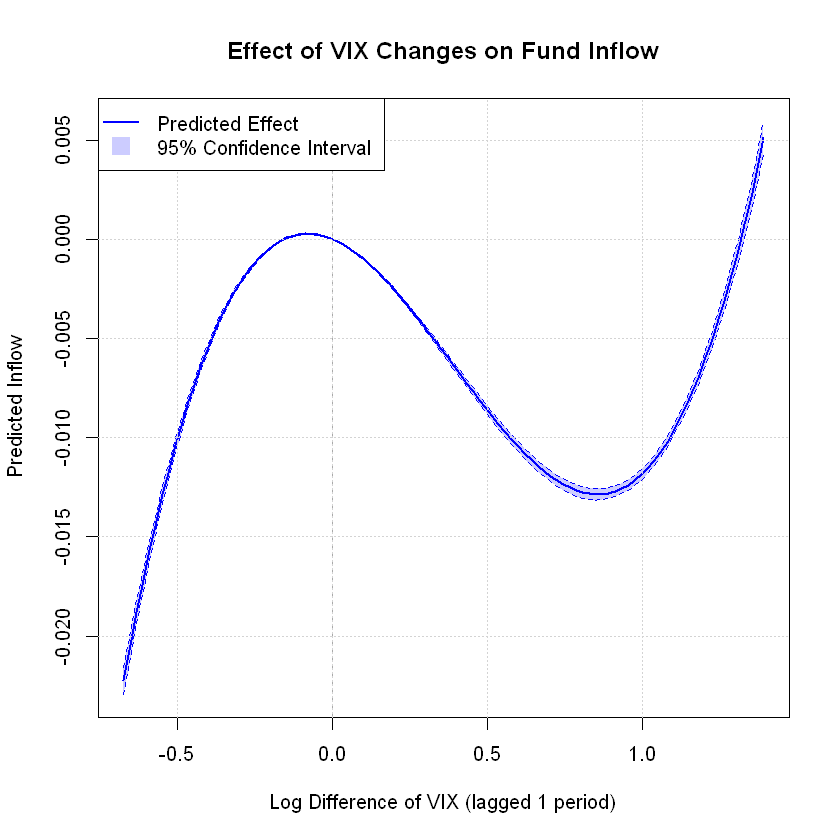

In [55]:
par(bg="white", mar=c(5, 4, 4, 2) + 0.1)

# Extract coefficients for log_diff_lag1 and its higher order terms
coefficients <- coef(model_b_1)
b1 <- coefficients["log_diff_lag1"]
b2 <- coefficients["I(log_diff_lag1^2)"]
b3 <- coefficients["I(log_diff_lag1^3)"]

# Use the range from the original gfc_indicators dataframe
min_value <- min(gfc_indicators$log_diff_lag1, na.rm = TRUE)
max_value <- max(gfc_indicators$log_diff_lag1, na.rm = TRUE)
log_diff_values <- seq(min_value, max_value, length.out = 100)

# Calculate predicted inflow for each value (partial effect, ignoring other variables)
predicted_inflow <- b1 * log_diff_values + 
                    b2 * log_diff_values^2 + 
                    b3 * log_diff_values^3

# Get the variance-covariance matrix for the coefficients
vcov_matrix <- vcovHC(model_b_1, type = "HC1") # Using robust variance-covariance matrix

# Extract the rows/columns for our parameters of interest
param_indices <- which(names(coefficients) %in% c("log_diff_lag1", "I(log_diff_lag1^2)", "I(log_diff_lag1^3)"))
vcov_subset <- vcov_matrix[param_indices, param_indices]

# Calculate standard error for each prediction point
se_predictions <- numeric(length(log_diff_values))
for (i in 1:length(log_diff_values)) {
    # Create X matrix for this prediction point
    X_i <- c(log_diff_values[i], log_diff_values[i]^2, log_diff_values[i]^3)
    
    # Calculate variance of prediction
    se_predictions[i] <- sqrt(t(X_i) %*% vcov_subset %*% X_i)
}

# Calculate confidence intervals (95%)
confidence_level <- 0.95
t_value <- qt((1 + confidence_level) / 2, df = df.residual(model_b_1))
upper_ci <- predicted_inflow + t_value * se_predictions
lower_ci <- predicted_inflow - t_value * se_predictions

# Create the plot
plot(log_diff_values, predicted_inflow, type = "l", lwd = 2, col = "blue",
     xlab = "Log Difference of VIX (lagged 1 period)",
     ylab = "Predicted Inflow",
     main = "Effect of VIX Changes on Fund Inflow",
     ylim = range(c(lower_ci, upper_ci)))

# Add confidence intervals
polygon(c(log_diff_values, rev(log_diff_values)), 
        c(lower_ci, rev(upper_ci)), 
        col = rgb(0, 0, 1, 0.2), border = NA)

# Add the CI lines
lines(log_diff_values, upper_ci, lty = 2, col = "blue")
lines(log_diff_values, lower_ci, lty = 2, col = "blue")

# Add a vertical line at x = 0 for reference
abline(v = 0, lty = 2, col = "darkgray")

# Add a grid for better readability
grid()

# Add a legend
legend("topleft", 
       legend = c("Predicted Effect", "95% Confidence Interval"),
       col = c("blue", rgb(0, 0, 1, 0.2)),
       lty = c(1, 0), 
       pch = c(NA, 15),
       pt.bg = rgb(0, 0, 1, 0.2),
       lwd = c(2, NA),
       pt.cex = 2,
       bg = "white")

- `International Capital Inflow` >> `Volatility`

In [56]:
library(plm)

# Run model with individual fixed effects and quarter dummies
model_b_2 <- plm(volatility_end ~ inflow +  Size + Lev + ROA + BM + Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
             data = panel_data, 
             model = "within", 
             effect = "individual")

# Display regression results
summary(model_b_2)

# Get robust standard errors for both models
library(lmtest)
library(sandwich)
cat("\nRobust standard errors for two-way fixed effects model:\n")
coeftest(model_b_2, vcov = vcovHC(model_b_2, type = "HC1"))

Oneway (individual) effect Within Model

Call:
plm(formula = volatility_end ~ inflow + Size + Lev + ROA + BM + 
    Board + Top1 + quarter + gdp_growth_rate + m2_growth_rate, 
    data = panel_data, effect = "individual", model = "within")

Balanced Panel: n = 127, T = 7, N = 3556

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.6235217 -0.0996885  0.0061141  0.0998493  0.5350678 

Coefficients:
                  Estimate Std. Error  t-value  Pr(>|t|)    
inflow          -1.9427205  0.1945213  -9.9872 < 2.2e-16 ***
Size            -0.0726360  0.0073810  -9.8409 < 2.2e-16 ***
Lev              0.2426603  0.0514326   4.7180 2.477e-06 ***
ROA              0.2652589  0.1118592   2.3714  0.017778 *  
BM              -0.0839278  0.0042218 -19.8794 < 2.2e-16 ***
Board            0.1103045  0.0335278   3.2899  0.001012 ** 
Top1             0.0357682  0.0602233   0.5939  0.552601    
quarter2        -0.0805818  0.0369300  -2.1820  0.029177 *  
quarter3        -0.0755472  0.


Robust standard errors for two-way fixed effects model:



t test of coefficients:

                 Estimate Std. Error  t value  Pr(>|t|)    
inflow          -1.942720   0.186786 -10.4008 < 2.2e-16 ***
Size            -0.072636   0.020436  -3.5543 0.0003842 ***
Lev              0.242660   0.142559   1.7022 0.0888127 .  
ROA              0.265259   0.256376   1.0346 0.3009072    
BM              -0.083928   0.010970  -7.6506 2.586e-14 ***
Board            0.110304   0.073426   1.5023 0.1331237    
Top1             0.035768   0.178526   0.2004 0.8412162    
quarter2        -0.080582   0.013945  -5.7784 8.219e-09 ***
quarter3        -0.075547   0.014529  -5.1998 2.112e-07 ***
quarter4        -0.094392   0.019197  -4.9170 9.201e-07 ***
gdp_growth_rate  0.191620   0.035211   5.4420 5.639e-08 ***
m2_growth_rate  -1.284466   0.484050  -2.6536 0.0080012 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


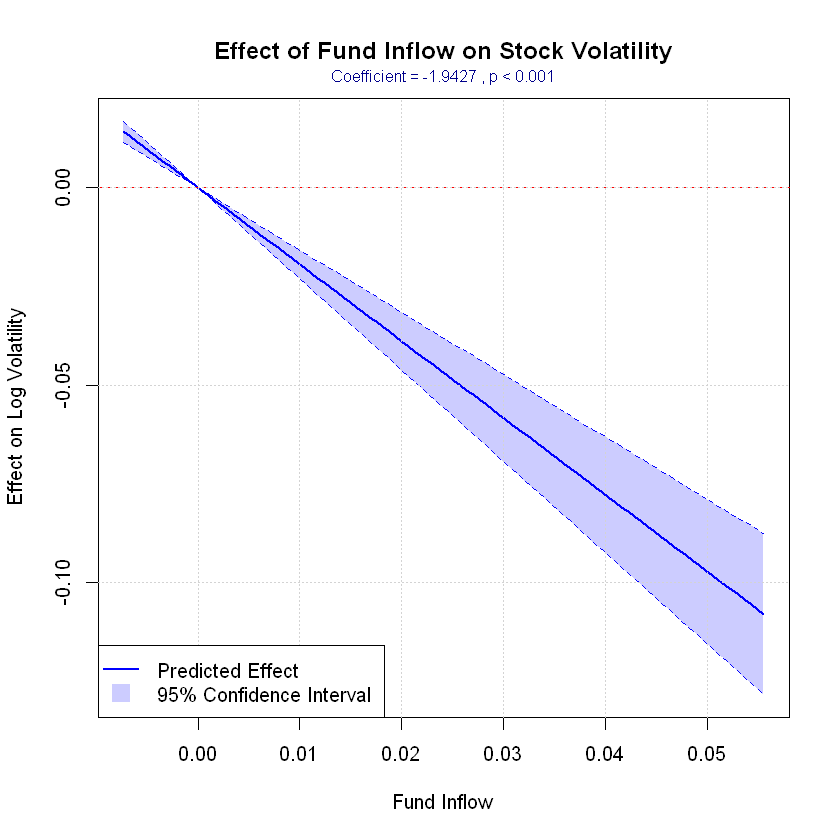

In [58]:
par(bg="white", mar=c(5, 4, 4, 2) + 0.1)

# Extract coefficient for inflow
coefficient <- coef(model_b_2)["inflow"]
vcov_matrix <- vcovHC(model_b_2, type = "HC1") 
se <- sqrt(vcov_matrix["inflow", "inflow"])

# Use the range from panel_data
min_value <- quantile(panel_data$inflow, 0.05, na.rm = TRUE)
max_value <- quantile(panel_data$inflow, 0.95, na.rm = TRUE)
inflow_values <- seq(min_value, max_value, length.out = 100)

# Calculate predicted change in volatility across the range
effect_values <- coefficient * inflow_values

# Calculate confidence intervals
t_value <- qt(0.975, df = df.residual(model_b_2))
ci_width <- t_value * se * abs(inflow_values)
upper_ci <- effect_values + ci_width
lower_ci <- effect_values - ci_width

# Create the plot
plot(inflow_values, effect_values, type = "l", lwd = 2, col = "blue",
    xlab = "Fund Inflow",
    ylab = "Effect on Log Volatility",
    main = "Effect of Fund Inflow on Stock Volatility",
    ylim = range(c(lower_ci, upper_ci, 0)))  # Include 0 in range

# Add confidence intervals
polygon(c(inflow_values, rev(inflow_values)), 
       c(lower_ci, rev(upper_ci)), 
       col = rgb(0, 0, 1, 0.2), border = NA)

# Add the CI lines
lines(inflow_values, upper_ci, lty = 2, col = "blue")
lines(inflow_values, lower_ci, lty = 2, col = "blue")

# Add a horizontal line at y = 0 for reference
abline(h = 0, lty = 2, col = "red")

# Add a grid for better readability
grid()

# Add a legend
legend("bottomleft", 
       legend = c("Predicted Effect", "95% Confidence Interval"),
       col = c("blue", rgb(0, 0, 1, 0.2)),
       lty = c(1, 0), 
       pch = c(NA, 15),
       pt.bg = rgb(0, 0, 1, 0.2),
       lwd = c(2, NA),
       pt.cex = 2,
       bg = "white")

# Add p-value information
p_value <- 2 * pt(-abs(coefficient/se), df = df.residual(model_b_2))
p_text <- if (p_value < 0.001) "p < 0.001" else paste("p =", round(p_value, 3))
mtext(paste("Coefficient =", round(coefficient, 4), ",", p_text), 
     side = 3, line = 0.5, col = "darkblue", cex = 0.8)